## Adaptive Filter for Advanced Acoustic Signal Segmentation
In the realm of monitoring of industrial applications, especially with acoustic signals, delineating different phases or regimes is crucial for understanding and optimizing various processes. Building on our previous work, we now venture into a more nuanced and challenging task: segmenting the acoustic signal into three predominant melting regimes:

- Conduction
- Stable Keyhole
- Unstable Keyhole

These regimes offer deeper insights into the acoustic behavior, enabling better control and optimization in applications such as welding, metal 3D printing, and other material processing techniques.

### Initialization of Filter Taps Using Trained Binary Filters
A distinctive feature of our approach in this notebook is the initialization of our adaptive filter. Instead of starting from scratch or using traditional methods, we utilize the filter taps from our previously trained binary filters. By doing so, we leverage the knowledge and patterns captured during the binary segmentation process to give our ternary segmentation filter a head start.

Specifically, the filter taps of the adaptive filter are initialized using the weights from the trained binary filters. This method not only speeds up the convergence but also enhances the robustness of the filter in handling complex acoustic signals, ensuring precise segmentation into the three melting regimes.

Incorporating a gradient-based optimization algorithm into this adaptive filter framework allows the filter to learn and adapt its weights based on the incoming data dynamically. Such adaptability is paramount in scenarios where signal characteristics can vary, ensuring the filter remains accurate throughout different conditions.

In the ensuing sections, we will detail the implementation, training methodologies, and visualize the results to demonstrate the efficacy of our approach in ternary acoustic signal segmentation.

In [1]:
# Import necessary libraries and packages
import random
import copy
import torch
import numpy as np
import pandas as pd
import scipy.signal
import seaborn as sns
from torch import nn, optim
import matplotlib.pyplot as plt
from torchmetrics import F1Score
from torch.nn import functional as F
from Architectures import AdaptiveFilter
from torchmetrics import Precision, Recall
from sklearn.metrics import confusion_matrix

# Set deterministic seed for reproducibility
seed = 1995
random.seed(seed)     # python's random generator
np.random.seed(seed)  # numpy's random generator
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define essential parameters
n_iters = 50   # Number of iterations
Fs = 2000000   # Sampling frequency
size = 2501    # Size for the FIR filter

# Initialize plotting in Jupyter
get_ipython().run_line_magic('matplotlib', 'notebook')

### Adaptive Filter Class Definition
The core of our approach lies in the 'AdaptiveFilter_Ter' class, our adaptive filter. This class is designed to process the input acoustic signals and produce ternary segmentation. The filter is initialized with weights derived from the previously trained binary models, ensuring a more informed start for the learning process.

The class comprises one filter and two moving averages, each followed by activation functions. The design ensures sequential processing of input data, effectively capturing and emphasizing the signal features that differentiate between the three melting regimes.

In [2]:
class AdaptiveFilter_Ter(nn.Module):
    def __init__(self, weigths_init, size):
        super(AdaptiveFilter_Ter, self).__init__()
        self.size = size*3
        rep = 1
        
        # Convert and reshape weights for initialization
        weights_init_torch = torch.tensor(weigths_init).view(1,1,-1).float().repeat(rep,1,1)
        
        # First filter with initialized weights
        self.smooth_filtKH = torch.nn.Conv1d(in_channels=1, out_channels=rep, kernel_size=size, padding='same')
        self.smooth_filtKH.weight = torch.nn.Parameter(weights_init_torch)
        
        # Activation layer after first filter
        self.prelu1 = torch.nn.PReLU()
        
        # Moving average 
        self.smooth_filt1 = torch.nn.Conv1d(in_channels=rep, out_channels=1, kernel_size=self.size, padding='same')
        self.smooth_filt1.weight = torch.nn.Parameter(torch.ones_like(self.smooth_filt1.weight)/self.size*rep)
        self.smooth_filt1.weight.requires_grad = False 
        
        # Activation layer after moving average
        self.prelu2 = torch.nn.PReLU()
        
        # Second moving average 
        self.smooth_filt2 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.size, padding='same')
        self.smooth_filt2.weight = torch.nn.Parameter(torch.ones_like(self.smooth_filt2.weight)/self.size)
        self.smooth_filt2.weight.requires_grad = False   

    def forward(self, x):
        # Normalization of the input tensor using quantiles
        myMax = torch.quantile(x, 0.99)
        myMin = torch.quantile(x, 0.01)
        x_norm = (x - myMin) / (myMax - myMin)
        
        # Sequential processing through filter, activation layers, and moving averages
        smoothed_x = self.smooth_filtKH(x_norm.view(1,1,-1))
        smoothed_x_energ = self.prelu1(smoothed_x)
        smoothed_x_energ_smooth = self.prelu2(self.smooth_filt1(smoothed_x_energ))
        smoothed_x_energ_smooth = self.smooth_filt2(smoothed_x_energ_smooth).view(-1,1)

        return smoothed_x_energ_smooth


### Pre-trained Binary Models Loading
To build upon the knowledge acquired in the binary segmentation phase, we load the pre-trained binary models. The weights from the Keyhole model will serve as an initialization for our ternary segmentation filter. By leveraging these pre-trained models, our filter gains a foundational understanding, allowing for faster convergence and improved accuracy.

In [3]:
models_Cond_old = torch.load('./Models/models_Cond_')
models_KH_old = torch.load('./Models/models_KH_')

In [4]:
weigths_init = models_KH_old[0].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

### Visualizing Initialized Weights
Before moving forward, it's insightful to visualize the weights that we've initialized. This visualization provides a glimpse into the characteristics of the filter taps and aids in understanding the transformation they'll impose on the input signals.

<IPython.core.display.Javascript object>


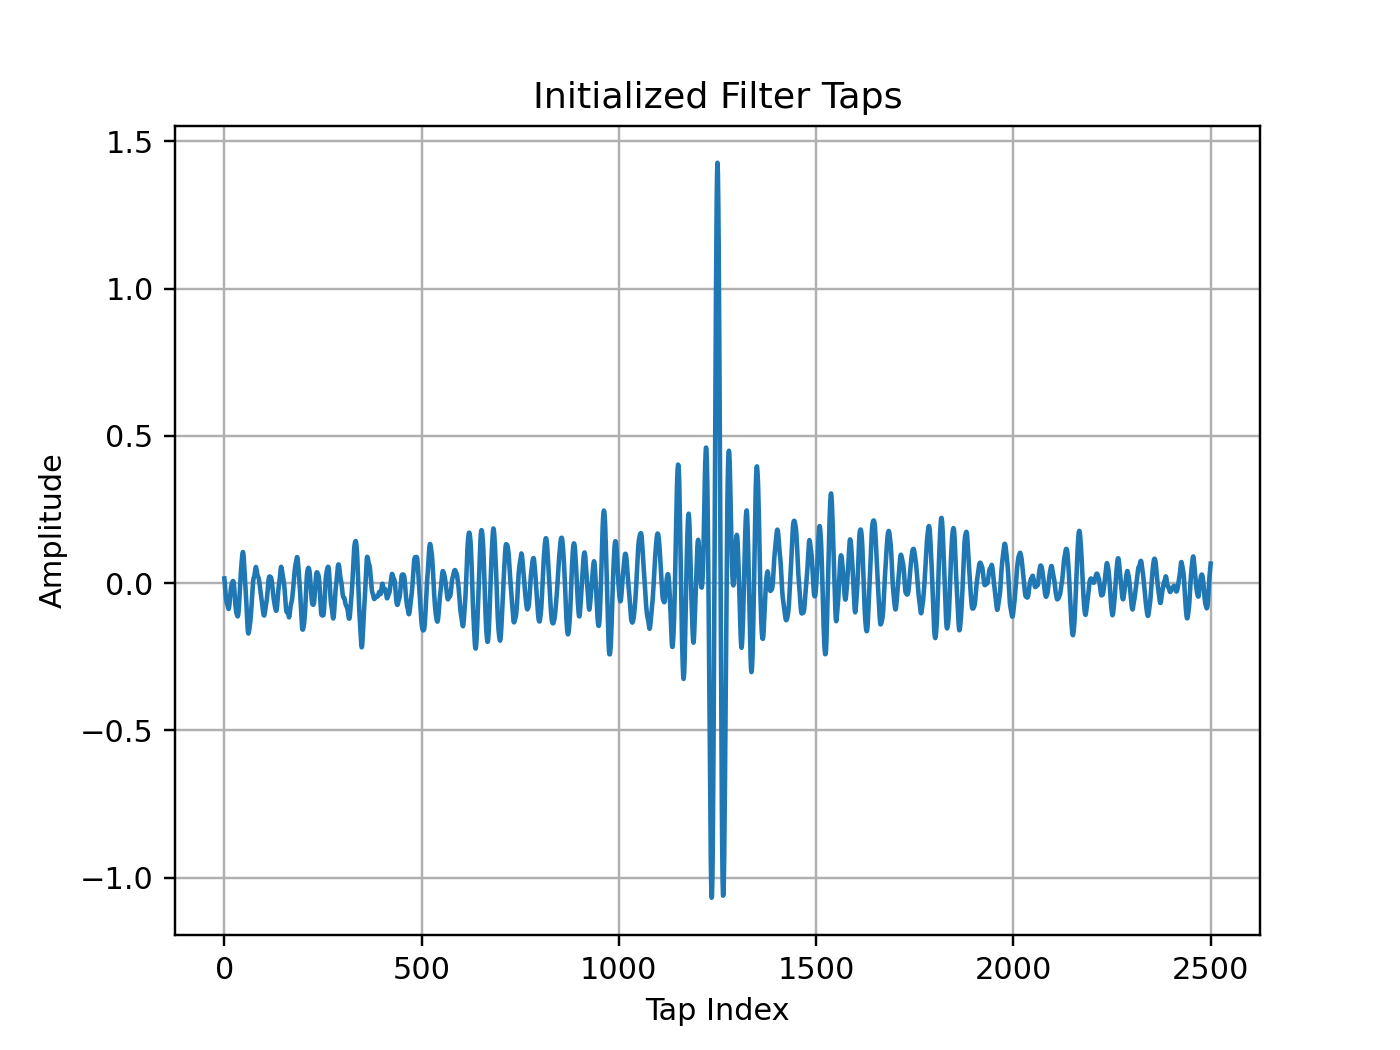

In [5]:
# Plot the initialized filter taps
plt.figure()
plt.plot(weigths_init[:])
plt.title("Initialized Filter Taps")
plt.xlabel("Tap Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Frequency Response Analysis of Initialized Filter
Every filter has an associated frequency response that dictates how different frequency components of a signal are amplified or attenuated. By analyzing this response, we can discern the filter's behavior and its potential impact on the input signals.

<IPython.core.display.Javascript object>


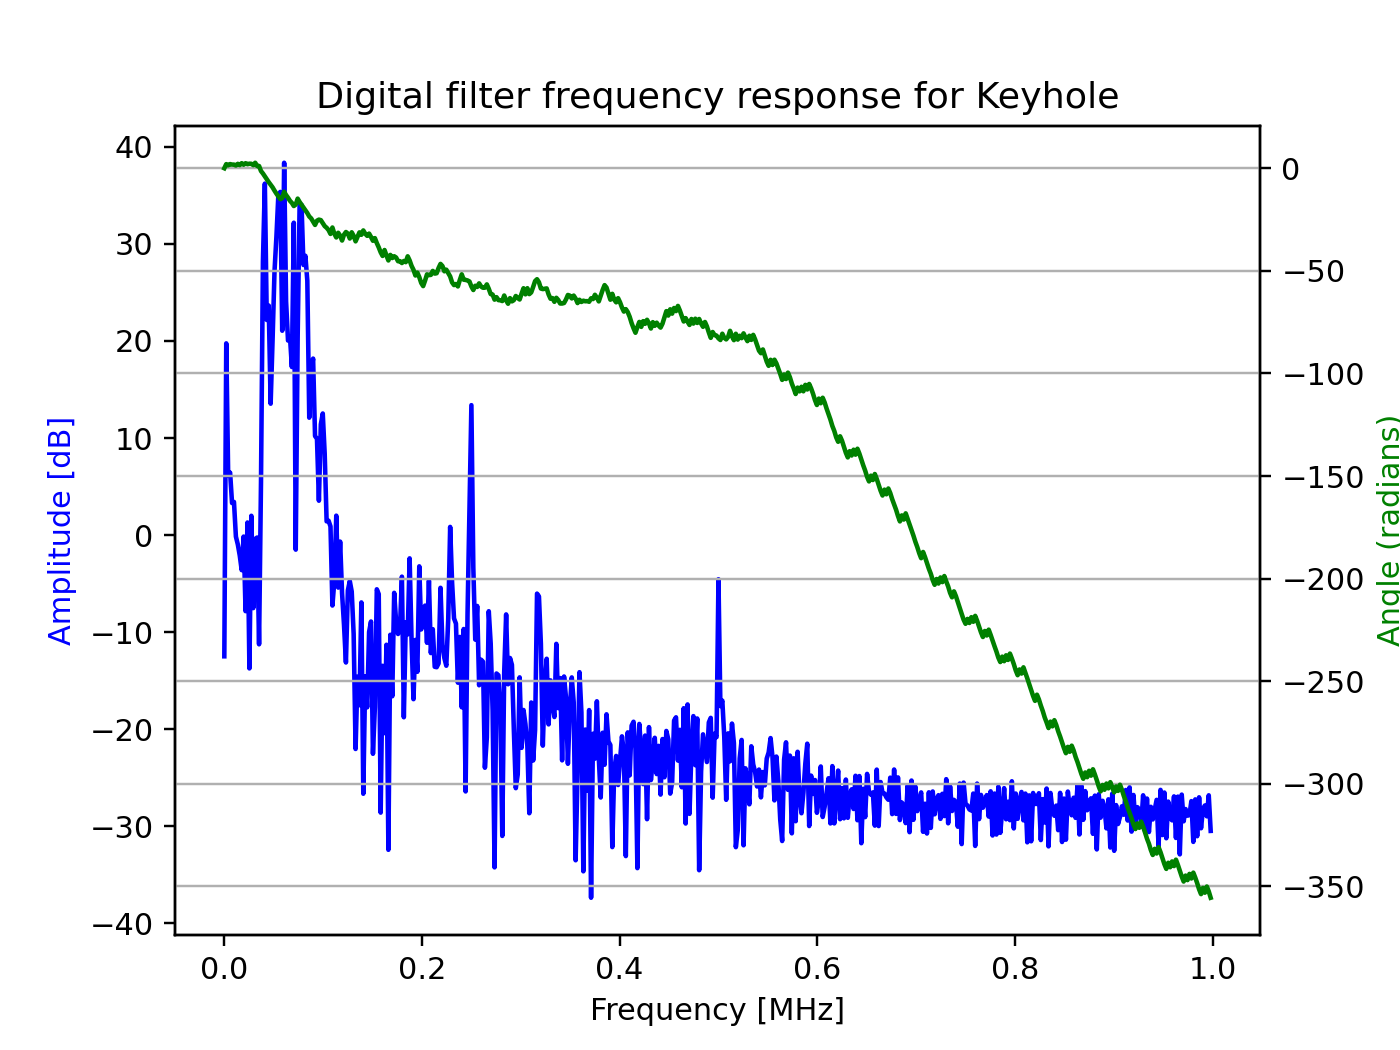

In [6]:
w, h = scipy.signal.freqz(weigths_init[:], fs=Fs)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response for Keyhole')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [7]:
weigths_init_cond = models_Cond_old[0].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

<IPython.core.display.Javascript object>


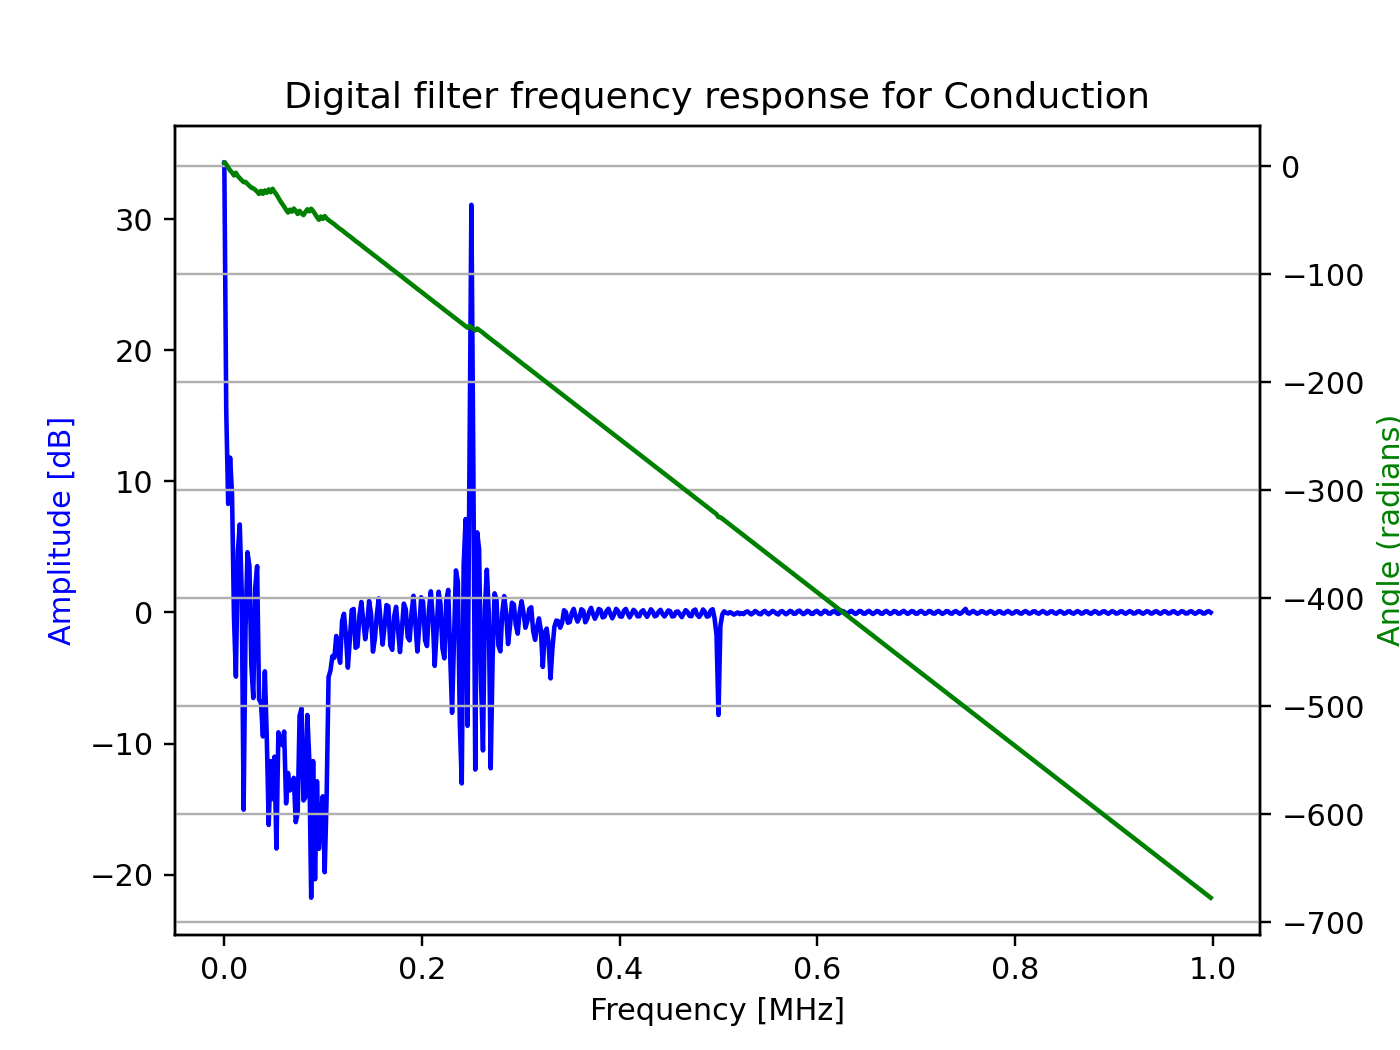

In [8]:
w, h = scipy.signal.freqz(weigths_init_cond[:], fs=Fs)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response for Conduction')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

### Database Loading
With the filter defined and weights initialized, the next step is to load our dataset. This dataset comprises acoustic signals corresponding to different melting regimes. We'll be using this data to train our filter and evaluate its performance.

In [9]:
xs = torch.load('./Database/Data')
GTs = torch.load('./Database/GTsTer')
names = torch.load('./Database/names')

In [10]:
names

['RM1', 'RM2', 'RM3', 'RM4', 'RM5', 'RM6', 'RM7_1', 'RM7_2', 'RM7_3']

### Sample Data Visualization
Before proceeding with the training and optimization processes, it's essential to visualize a sample from our dataset. This visualization provides insights into the signal characteristics and the corresponding ground truth labels, aiding in understanding the nature of the segmentation task ahead.

<IPython.core.display.Javascript object>


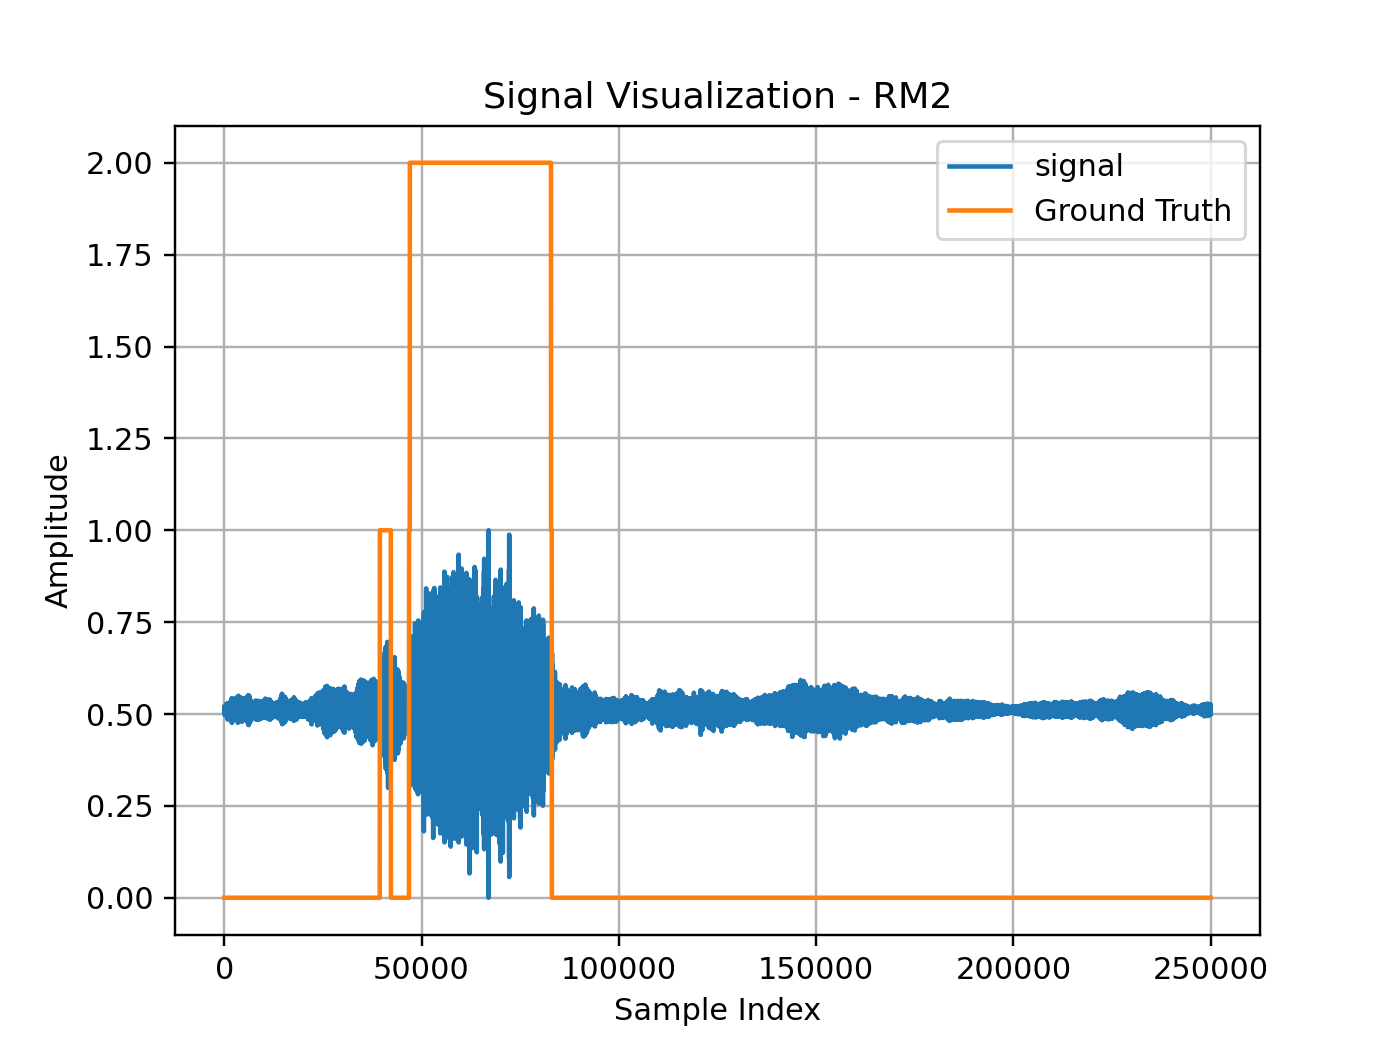

In [11]:
index = torch.randint(low=0, high=len(xs), size=(1,))
plt.figure()
signal = xs[index].view(-1).numpy()
plt.plot((signal-min(signal))/(max(signal)-min(signal)), label='signal')
plt.plot(GTs[index], label='Ground Truth')
plt.legend()
plt.title(f"Signal Visualization - {names[index]}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### GPU Device Configuration
To expedite computations, especially in deep learning tasks, it's common to utilize GPU (Graphics Processing Unit) devices. This segment checks if a GPU is available and sets the computation device accordingly. If no GPU is available, computations will default to the CPU (Central Processing Unit).

In [12]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

### Closure Function for Optimization
The closure function calculates the loss (or risk) across the dataset for the given predictions. This function excludes the data sample at the index outer to ensure that we're evaluating the model's performance on unseen data. This approach adopt leave-one-out cross-validation method, a popular technique for model validation.

In [13]:
def closure():
    total_risk = 0
    num_samples = 0

    for i, (name, current_GT, current_signal) in enumerate(zip(names, GTs, xs)):
        if i != outer:
            current_GT, current_signal = current_GT.to(device), current_signal.to(device)

            x_Cond = prediction(current_signal)
            x_KH = predictionKH(current_signal)
            x_Unst = predictionUnst(current_signal)

            predictions_combined = torch.cat([x_Cond, x_KH, x_Unst], dim=1)
            _, predicted_class = torch.max(predictions_combined, 1)

            current_loss = loss(predictions_combined, current_GT.view(-1).long())

            total_risk += current_loss
            num_samples += predictions_combined.shape[0]

    average_risk = total_risk / (len(xs) - 1)
    return average_risk


### Training Procedure for Multi-Regime Acoustic Signal Segmentation

The subsequent code block represents the central training loop for optimizing our models to segment the acoustic signal into three primary melting regimes:

1. **Conduction**
2. **Stable Keyhole**
3. **Unstable Keyhole**

The process can be broken down into the following steps:

- **Initialization**: 
  - Various parameters are set, pre-trained models are loaded, and new models are initialized.

- **Training Loop**: For each data sample:
  - The current data sample is excluded, following the leave-one-out cross-validation (LOOCV) methodology.
  - Models are initialized with weights from earlier trained binary models, which were also trained using the LOOCV strategy.
  - Regime weights are computed to address the issue of regime imbalance.
  - The L-BFGS optimization algorithm is then employed to fine-tune the models.
  - The model's performance is periodically assessed on the excluded sample, and the best models are saved, ensuring compliance with the LOOCV strategy.

- **Evaluation**: 
  - After the training phase, the performance of the models is evaluated on unseen signals.

This iterative procedure ensures that our models are robust and able to generalize well across the entire dataset.


In [14]:
# Enable anomaly detection to track operations that produce NaNs
torch.autograd.set_detect_anomaly(True)

# Parameter initialization
lr_init = 1.0
gamma = 0.00001
n_classes = 3
num_dec = 5

# Setting up metrics and placeholders
F1 = F1Score(task='multiclass', num_classes=n_classes, average='none').to(device)
F1_scores = []
test_names = []
models_Cond = []
models_KH = []
models_Unst = []

# Main loop across all data samples
for outer in range(len(xs)):
    print(f'Starting training without: {names[outer]}')

    # Parameter reset for each iteration
    old_risk = 0    
    min_risk = 1e12
    best_f1 = 0
    weights = np.zeros(n_classes)
    total = 0
    counter_flat = 0

    # Initialize models using weights from old models
    weights_init_cond = models_Cond_old[outer].smooth_filtKH.weight.detach().cpu().view(-1).numpy()
    weights_init_kh = models_KH_old[outer].smooth_filtKH.weight.detach().cpu().view(-1).numpy()

    prediction = AdaptiveFilter_Ter(weights_init_cond, size).to(device)
    predictionKH = AdaptiveFilter_Ter(weights_init_kh, size).to(device)
    predictionUnst = AdaptiveFilter_Ter(weights_init_kh, size).to(device)  # Initialized with KH weights as starting guess

    # Compute regime weights for CrossEntropyLoss to handle regime imbalances
    for i in range(len(xs)):
        if i != outer:
            GT = GTs[i]
            total += GT.shape[0]
            for c in range(n_classes):
                weights[c] += torch.sum(GT == c)
                
    weights = total / (n_classes * weights)
    loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))

    # Training loop
    done = False
    n = 0
    while not done:
        print(f'Starting epoch: {n}')
        
        # Learning rate adjustments
        if n == 0 or time_is_now:
            print('-------------- Reinitialized optim --------------')
            lr = abs(lr_init + torch.randn(1) * lr_init).item()
            print(f'LR: {lr}')
            
            params = list(prediction.parameters()) + list(predictionKH.parameters()) + list(predictionUnst.parameters())
            optimizer = optim.LBFGS(params, lr=lr, line_search_fn="strong_wolfe")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
            
            time_is_now = False

        risk = 0
        scores = []
        predictions = []
        groundis = []
        optimizer.zero_grad()

        # Iterate through data samples
        for i in range(len(xs)):
            if i != outer:
                name = names[i]
                GT = GTs[i].to(device)
                signal = xs[i].to(device)

                # Adding noise if the risk is not decreasing
                if counter_flat >= 50:
                    signal += torch.randn(signal.shape).to(device) * (torch.max(signal) - torch.min(signal))
                    print("Adding noise")

                # Predictions
                x_Cond = prediction(signal)
                x_KH = predictionKH(signal)
                x_Unst = predictionUnst(signal)
                myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
                
                # Loss computation
                _, ind = torch.max(myPreds, 1)
                loss_value = loss(myPreds, GT.view(-1).long())
                
                risk += loss_value
                predictions.append(ind.long())
                groundis.append(GT.view(-1).long())
                
                # Score computation
                score = F1(ind.long(), GT.view(-1).long())
                scores.append(score.view(1, -1))
                print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')

        risk /= (len(xs) - 1)

        # Update best models if current risk is the lowest
        if risk.item() < min_risk:
            min_risk = risk.item()
            torch.save(prediction, f'./PocketModels/predictionCicc_{outer}')
            torch.save(predictionKH, f'./PocketModels/predictionKHCicc_{outer}')
            torch.save(predictionUnst, f'./PocketModels/predictionUNSTCicc_{outer}')

        # Print metrics
        f1_score_total = F1(torch.cat(predictions), torch.cat(groundis))
        print(f'Risk: {round(risk.item(), num_dec)}, min Risk: {round(min_risk, num_dec)}')
        print(f'Total F1-score Cond: {f1_score_total[0].item()}')
        print(f'Total F1-score KHSt: {f1_score_total[1].item()}')
        print(f'Total F1-score KHUnst: {f1_score_total[2].item()}')
        print('---' * 19)

        # Evaluate the model on the test sample after certain epochs
        if n % 2 == 0:
            with torch.no_grad():
                name = names[outer]
                GT = GTs[outer].to(device)
                signal = xs[outer].to(device)

                x_Cond = prediction(signal)
                x_KH = predictionKH(signal)
                x_Unst = predictionUnst(signal)
                
                myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
                _, ind = torch.max(myPreds, 1)
                score = F1(ind.long(), GT.view(-1).long())
                
                # Track the best score
                if torch.mean(score) > best_f1:
                    best_f1 = torch.mean(score)
                    myN = n
                    myF1 = score.to('cpu').detach()

                print(f'Testing on: {name}')
                print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')
                print(f'Best F1: {myF1}, iter: {myN}')
                print('----' * 50)

        n += 1
        
        # Termination conditions for the training loop
        if (n >= n_iters and min_risk < 0.1) or n >= 10000 or (counter_flat == 50 and min_risk < 0.50):
            done = True

        scheduler.step(risk)
        risk.backward()
        optimizer.step(closure)  
        new_risk = risk.clone().item()

        # Track if risk is not decreasing
        if abs(new_risk - old_risk) < 0.00001:
            time_is_now = True
            counter_flat += 1
        else:
            counter_flat = 0

        old_risk = new_risk

    # Load the best models and evaluate their performance
    prediction_test = torch.load(f'./PocketModels/predictionCicc_{outer}')
    predictionKH_test = torch.load(f'./PocketModels/predictionKHCicc_{outer}')
    predictionUnst_test = torch.load(f'./PocketModels/predictionUNSTCicc_{outer}')

    with torch.no_grad():
        name = names[outer]
        GT = GTs[outer].to(device)
        signal = xs[outer].to(device)

        x_Cond = prediction_test(signal)
        x_KH = predictionKH_test(signal)
        x_Unst = predictionUnst_test(signal)
        
        myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
        _, ind = torch.max(myPreds, 1)
        score = F1(ind.long(), GT.view(-1).long())

        print(f'Testing on: {name}')
        print(f'F1-score: {score.to("cpu").detach()}, Name: {name}')
        print('----' * 50)

        # Storing the results
        F1_scores.append(score.view(1, -1))
        test_names.append(name)
        models_Cond.append(prediction_test)
        models_KH.append(predictionKH_test)
        models_Unst.append(predictionUnst_test)


Starting training without: RM1
Starting epoch: 0
-------------- Reinitialized optim --------------
LR: 0.0564611554145813
F1-score: tensor([0.0000, 0.0253, 0.0000]), Name: RM2
F1-score: tensor([0.0000, 0.0084, 0.0000]), Name: RM3
F1-score: tensor([0.0000, 0.8890, 0.0000]), Name: RM4
F1-score: tensor([0.0000, 0.8427, 0.0000]), Name: RM5
F1-score: tensor([0.0000, 0.1230, 0.0000]), Name: RM6
F1-score: tensor([0.0000, 0.1530, 0.0000]), Name: RM7_1
F1-score: tensor([0.0000, 0.2088, 0.0000]), Name: RM7_2
F1-score: tensor([0.0000, 0.2551, 0.0000]), Name: RM7_3
Risk: 1.35292, min Risk: 1.35292
Total F1-score Cond: 0.0
Total F1-score KHSt: 0.23382897675037384
Total F1-score KHUnst: 0.0
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.0000, 0.5638, 0.0000]), Name: RM1
Best F1: tensor([0.0000, 0.5638, 0.0000]), iter: 0
---------------------------------------------------------------------------------------------------------------------------------------

Starting epoch: 10
F1-score: tensor([0.8479, 0.0905, 0.8623]), Name: RM2
F1-score: tensor([0.7256, 0.0095, 0.4748]), Name: RM3
F1-score: tensor([0.5083, 0.9498, 0.8149]), Name: RM4
F1-score: tensor([0.4469, 0.8625, 0.0000]), Name: RM5
F1-score: tensor([0.8981, 0.2690, 0.6493]), Name: RM6
F1-score: tensor([0.9154, 0.2690, 0.5877]), Name: RM7_1
F1-score: tensor([0.8578, 0.3888, 0.6865]), Name: RM7_2
F1-score: tensor([0.8791, 0.3864, 0.5357]), Name: RM7_3
Risk: 0.87413, min Risk: 0.87413
Total F1-score Cond: 0.8520135283470154
Total F1-score KHSt: 0.39253419637680054
Total F1-score KHUnst: 0.59544438123703
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.7893, 0.7340, 0.5844]), Name: RM1
Best F1: tensor([0.7893, 0.7340, 0.5844]), iter: 10
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting

F1-score: tensor([0.8858, 0.3769, 0.5011]), Name: RM7_3
Risk: 0.85136, min Risk: 0.85136
Total F1-score Cond: 0.8400610089302063
Total F1-score KHSt: 0.37724244594573975
Total F1-score KHUnst: 0.5568561553955078
---------------------------------------------------------
Starting epoch: 20
F1-score: tensor([0.7940, 0.0732, 0.8564]), Name: RM2
F1-score: tensor([0.7288, 0.0092, 0.4434]), Name: RM3
F1-score: tensor([0.5272, 0.9467, 0.7797]), Name: RM4
F1-score: tensor([0.4682, 0.8638, 0.0000]), Name: RM5
F1-score: tensor([0.9024, 0.2464, 0.5655]), Name: RM6
F1-score: tensor([0.9199, 0.2563, 0.5420]), Name: RM7_1
F1-score: tensor([0.8593, 0.3772, 0.6604]), Name: RM7_2
F1-score: tensor([0.8858, 0.3769, 0.5011]), Name: RM7_3
Risk: 0.85136, min Risk: 0.85136
Total F1-score Cond: 0.8400610089302063
Total F1-score KHSt: 0.3772435188293457
Total F1-score KHUnst: 0.5568596720695496
---------------------------------------------------------
Testing on: RM1
F1-score: tensor([0.7722, 0.7246, 0.5615]), 

F1-score: tensor([0.9785, 0.5961, 0.9590]), Name: RM6
F1-score: tensor([0.9663, 0.7857, 0.9818]), Name: RM7_1
F1-score: tensor([0.9570, 0.6315, 0.9360]), Name: RM7_2
F1-score: tensor([0.9681, 0.6720, 0.9370]), Name: RM7_3
Risk: 0.73392, min Risk: 0.73392
Total F1-score Cond: 0.9662705659866333
Total F1-score KHSt: 0.6884008646011353
Total F1-score KHUnst: 0.932567298412323
---------------------------------------------------------
Starting epoch: 30
F1-score: tensor([0.9735, 0.0511, 0.9433]), Name: RM2
F1-score: tensor([0.9432, 0.0000, 0.7800]), Name: RM3
F1-score: tensor([0.8436, 0.9034, 0.6933]), Name: RM4
F1-score: tensor([0.9021, 0.9247, 0.6691]), Name: RM5
F1-score: tensor([0.9781, 0.6069, 0.9460]), Name: RM6
F1-score: tensor([0.9648, 0.7358, 0.9708]), Name: RM7_1
F1-score: tensor([0.9603, 0.6529, 0.9236]), Name: RM7_2
F1-score: tensor([0.9671, 0.7783, 0.9495]), Name: RM7_3
Risk: 0.73199, min Risk: 0.73199
Total F1-score Cond: 0.964159369468689
Total F1-score KHSt: 0.68401861190795

KeyboardInterrupt: 

### Impulse Response Visualization for Different Filters

In this section, we visually analyze the impulse responses of three key filters:

1. **Conduction Filter:** Compares the impulse response of the trained Conduction filter against its initial configuration.
2. **Stable Keyhole Filter:** Showcases the impulse response of the trained Stable Keyhole filter juxtaposed with its initial setup.
3. **Unstable Keyhole Filter:** Illustrates the impulse response of the trained Unstable Keyhole filter. It's noteworthy that the initial response for the Unstable Keyhole filter is the same as that of the Stable Keyhole filter.

Each plot emphasizes the differences between the initial and trained configurations, offering insights into how training has modified and optimized the filter's characteristics.


<IPython.core.display.Javascript object>


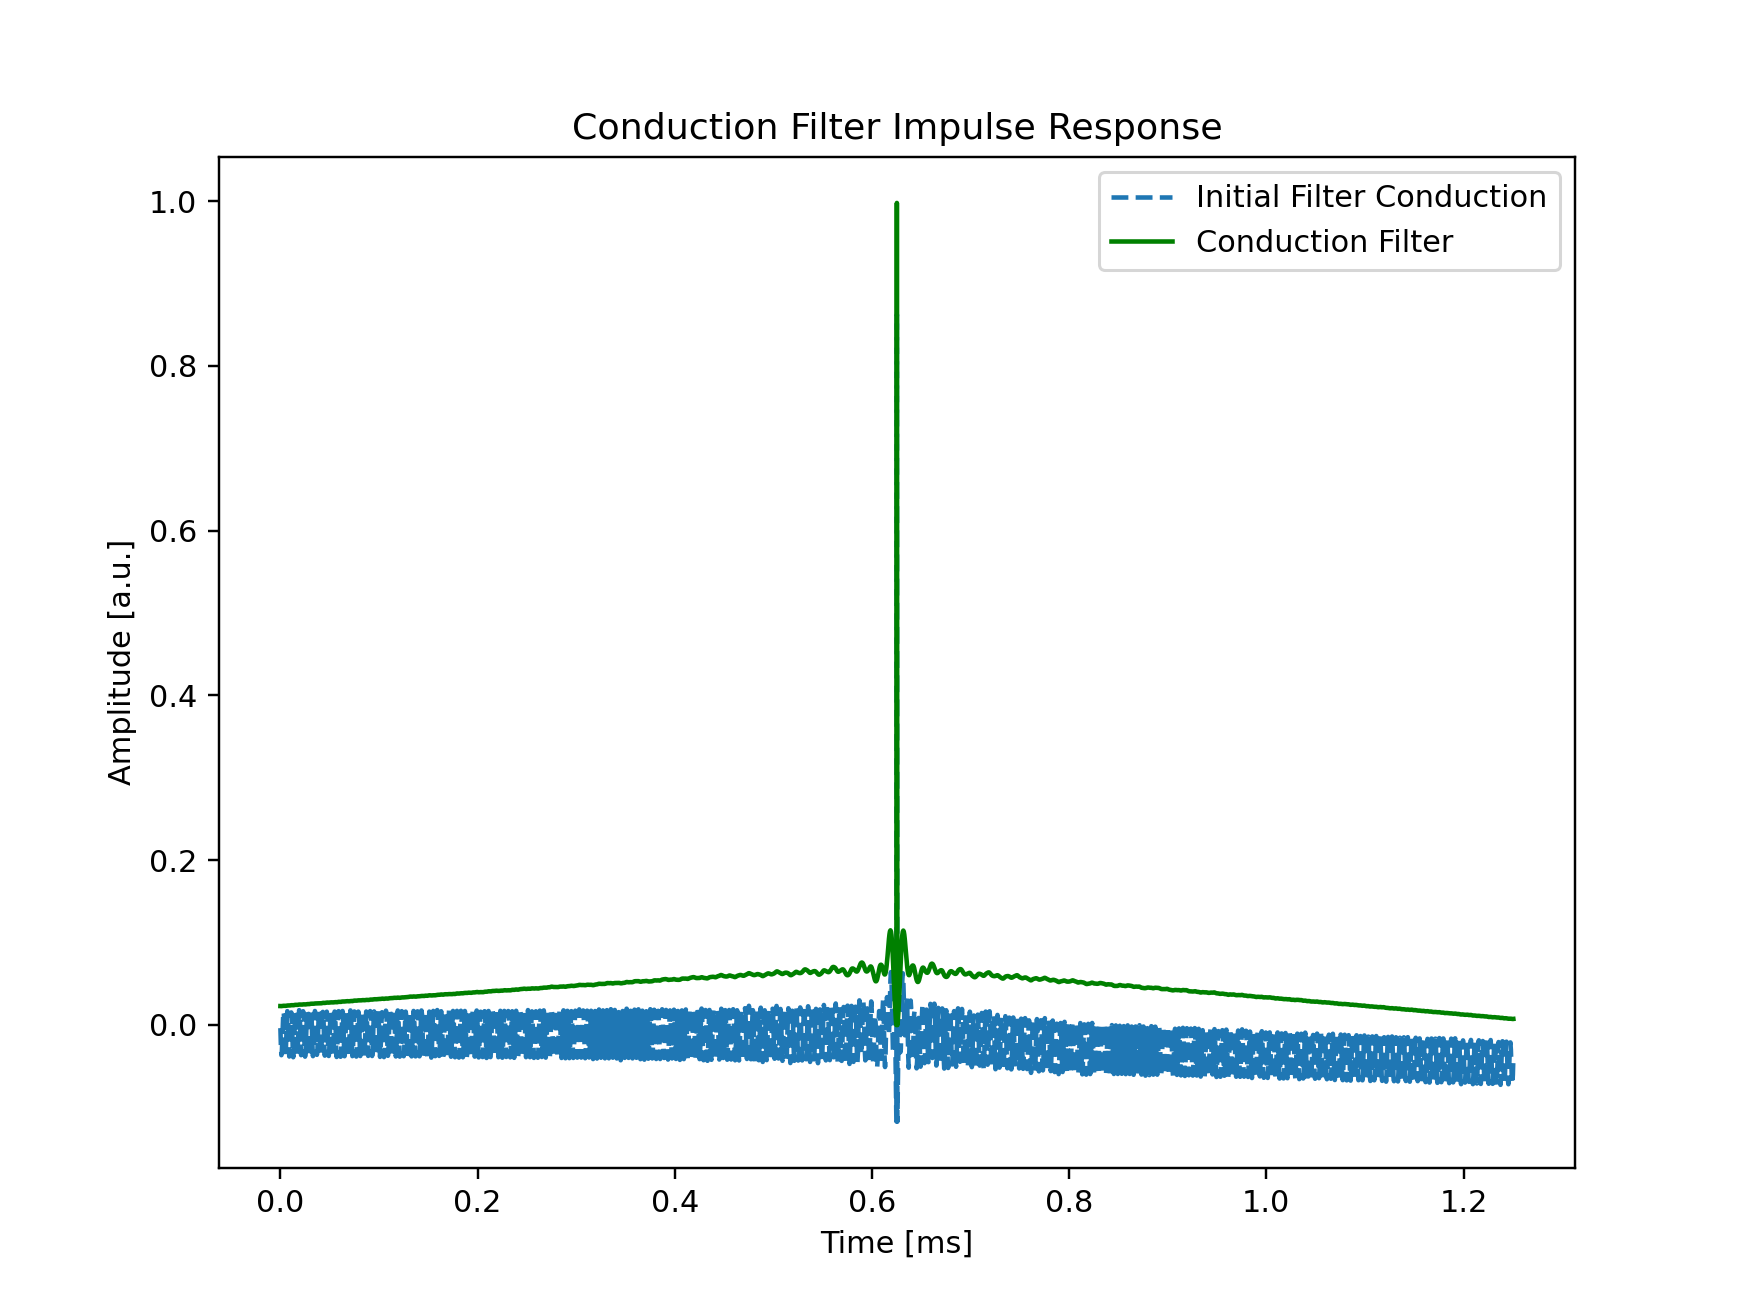

<IPython.core.display.Javascript object>


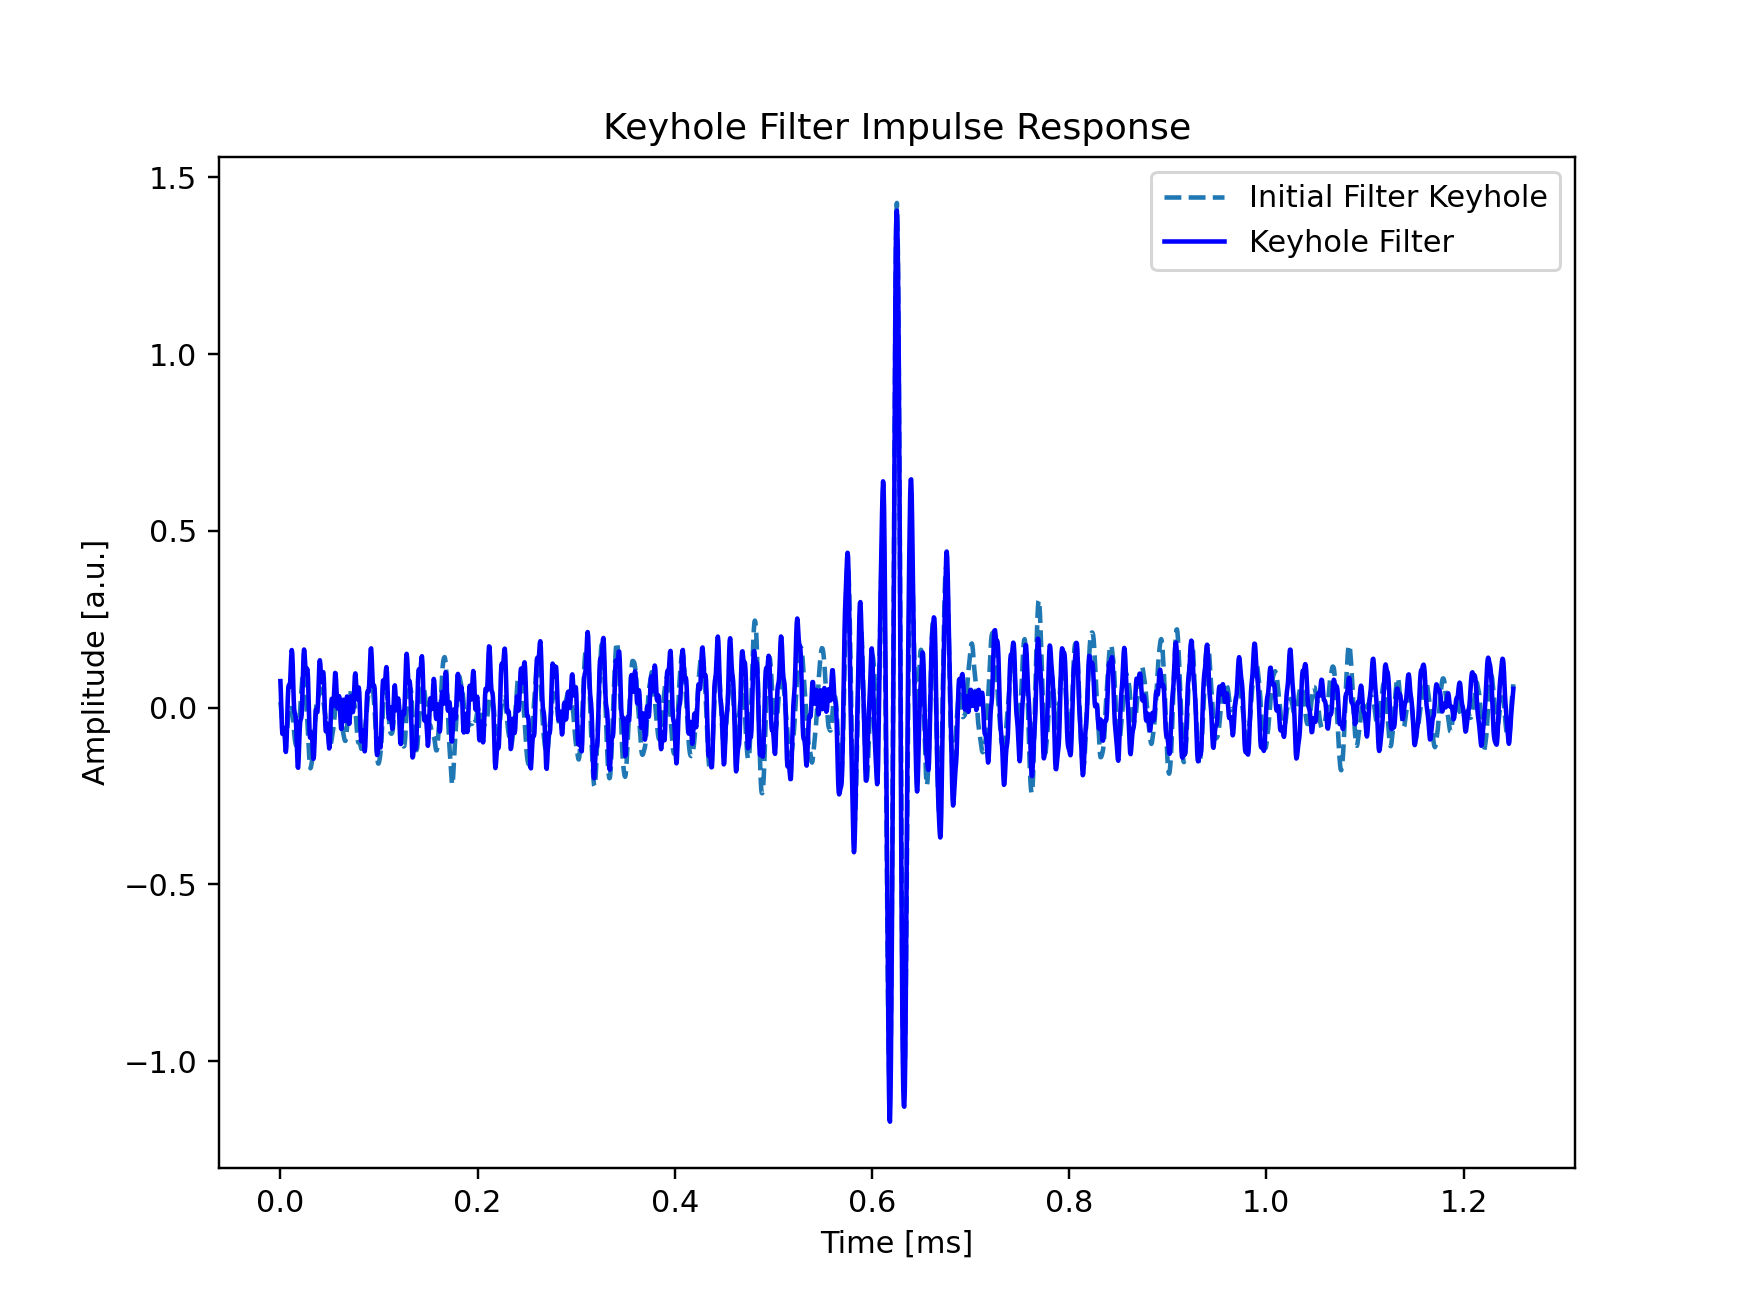

<IPython.core.display.Javascript object>


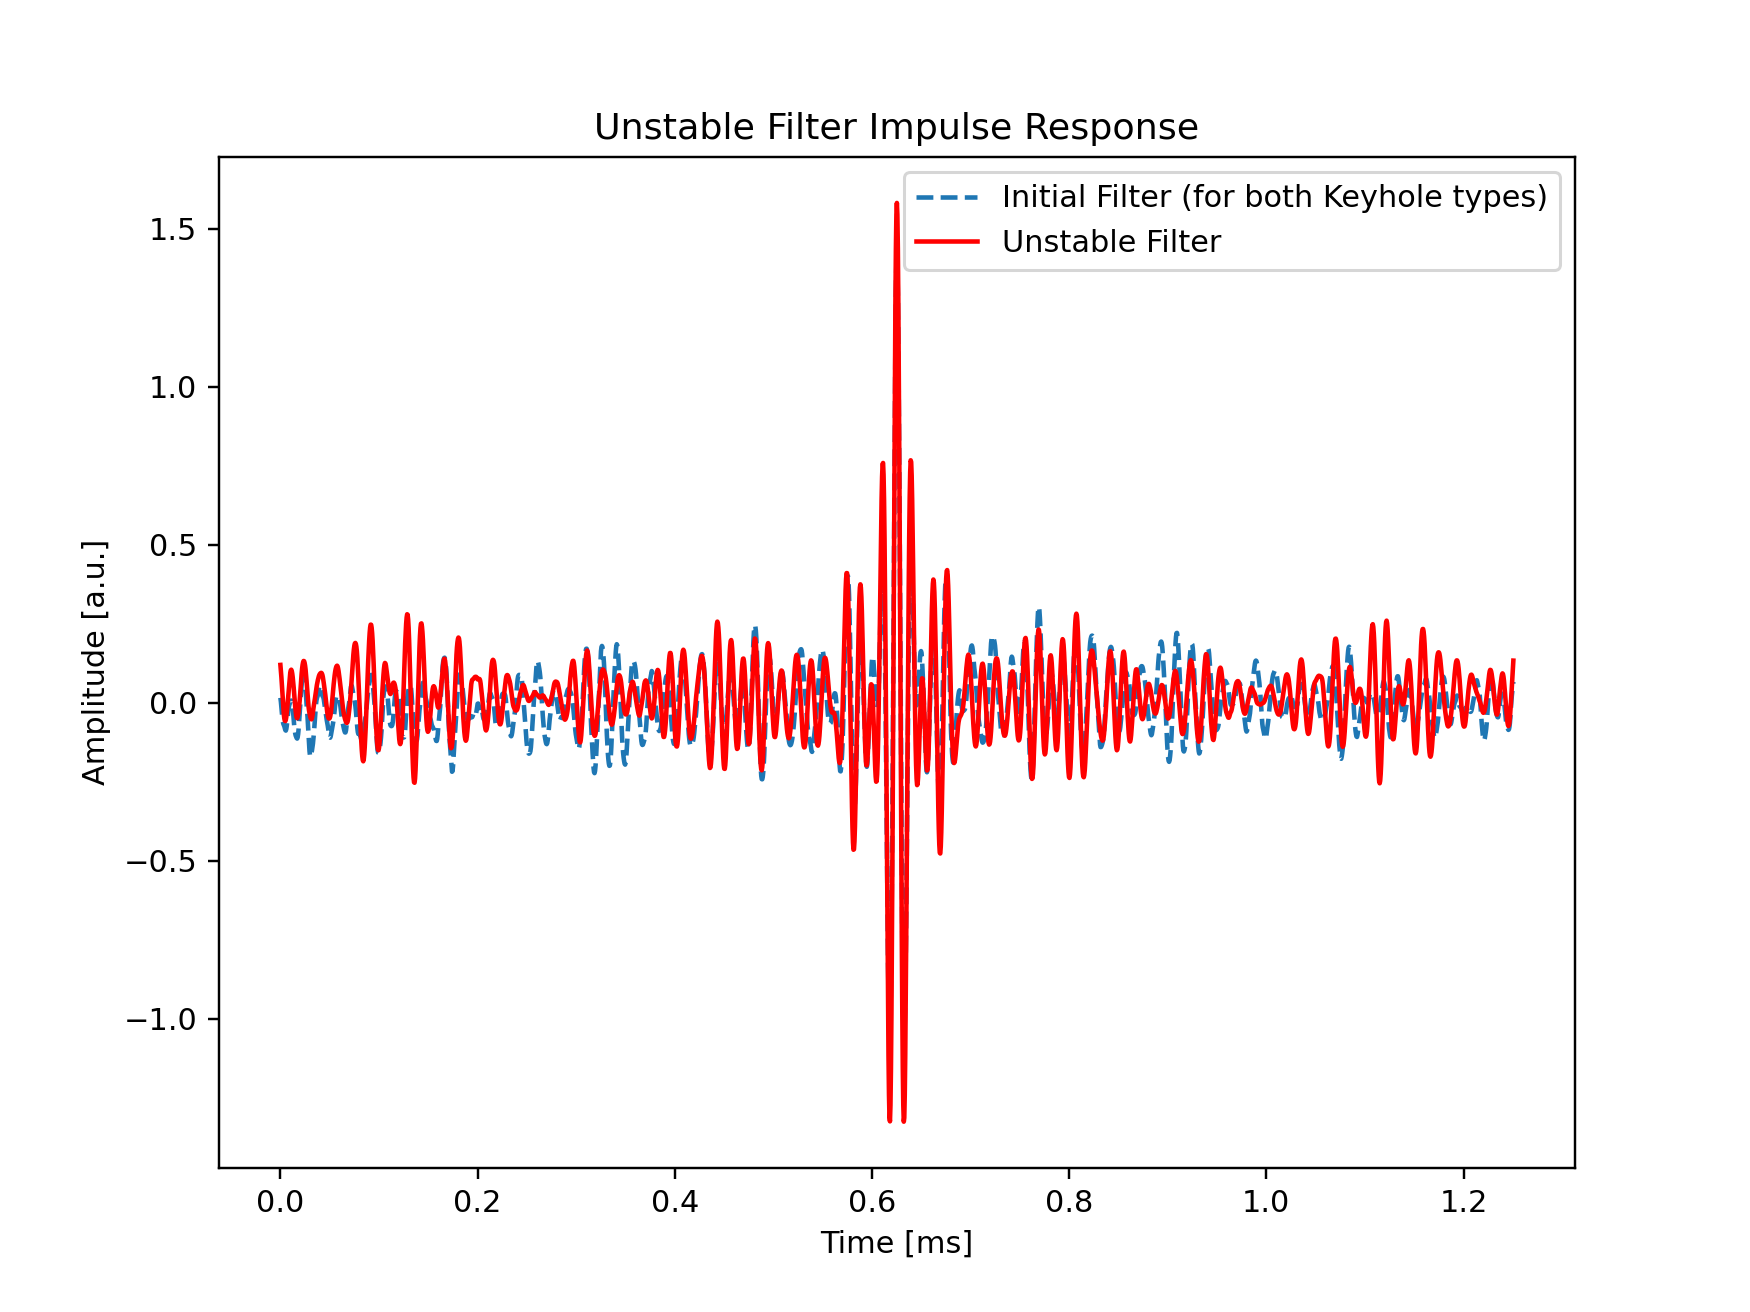

In [18]:
# Compute time array
num_samples = len(weigths_init)
time_array = np.linspace(0, num_samples / Fs, num_samples) * 1000  # in milliseconds

# Retrieve filter weights (impulse response) for the three models
weights_cond = prediction.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + prediction.smooth_filtKH.bias.cpu().detach().numpy()
weights_kh = predictionKH.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionKH.smooth_filtKH.bias.cpu().detach().numpy()
weights_unst = predictionUnst.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionUnst.smooth_filtKH.bias.cpu().detach().numpy()

# Plot for Conduction filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init_cond, label='Initial Filter Conduction', linestyle='--')
plt.plot(time_array, weights_cond, label='Conduction Filter', color='green')
plt.legend()
plt.title('Conduction Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()

# Plot for Stable Keyhole filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init, label='Initial Filter Keyhole', linestyle='--')
plt.plot(time_array, weights_kh, label='Keyhole Filter', color='blue')
plt.legend()
plt.title('Keyhole Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()

# Plot for Unstable Keyhole filter and its initial response
plt.figure(figsize=(8, 6))
plt.plot(time_array, weigths_init, label='Initial Filter (for both Keyhole types)', linestyle='--')
plt.plot(time_array, weights_unst, label='Unstable Filter', color='red')
plt.legend()
plt.title('Unstable Filter Impulse Response')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [a.u.]')
plt.show()


### Frequency Response Visualization for Different Filters

In this section, we delve into the frequency response characteristics of our filters:

1. **Conduction Filter:** A side-by-side comparison of the initial and trained Conduction filter's frequency response, highlighting the spectral modifications that have taken place during the training phase.
2. **Keyhole Filters (Stable and Unstable):** The frequency responses of both the trained Stable and Unstable Keyhole filters are displayed. For reference, the initial frequency response, which is shared by both types of Keyhole filters, is also plotted.

The frequency response plots serve as a spectral analysis tool, elucidating how each filter processes different frequency components before and after training.


<IPython.core.display.Javascript object>


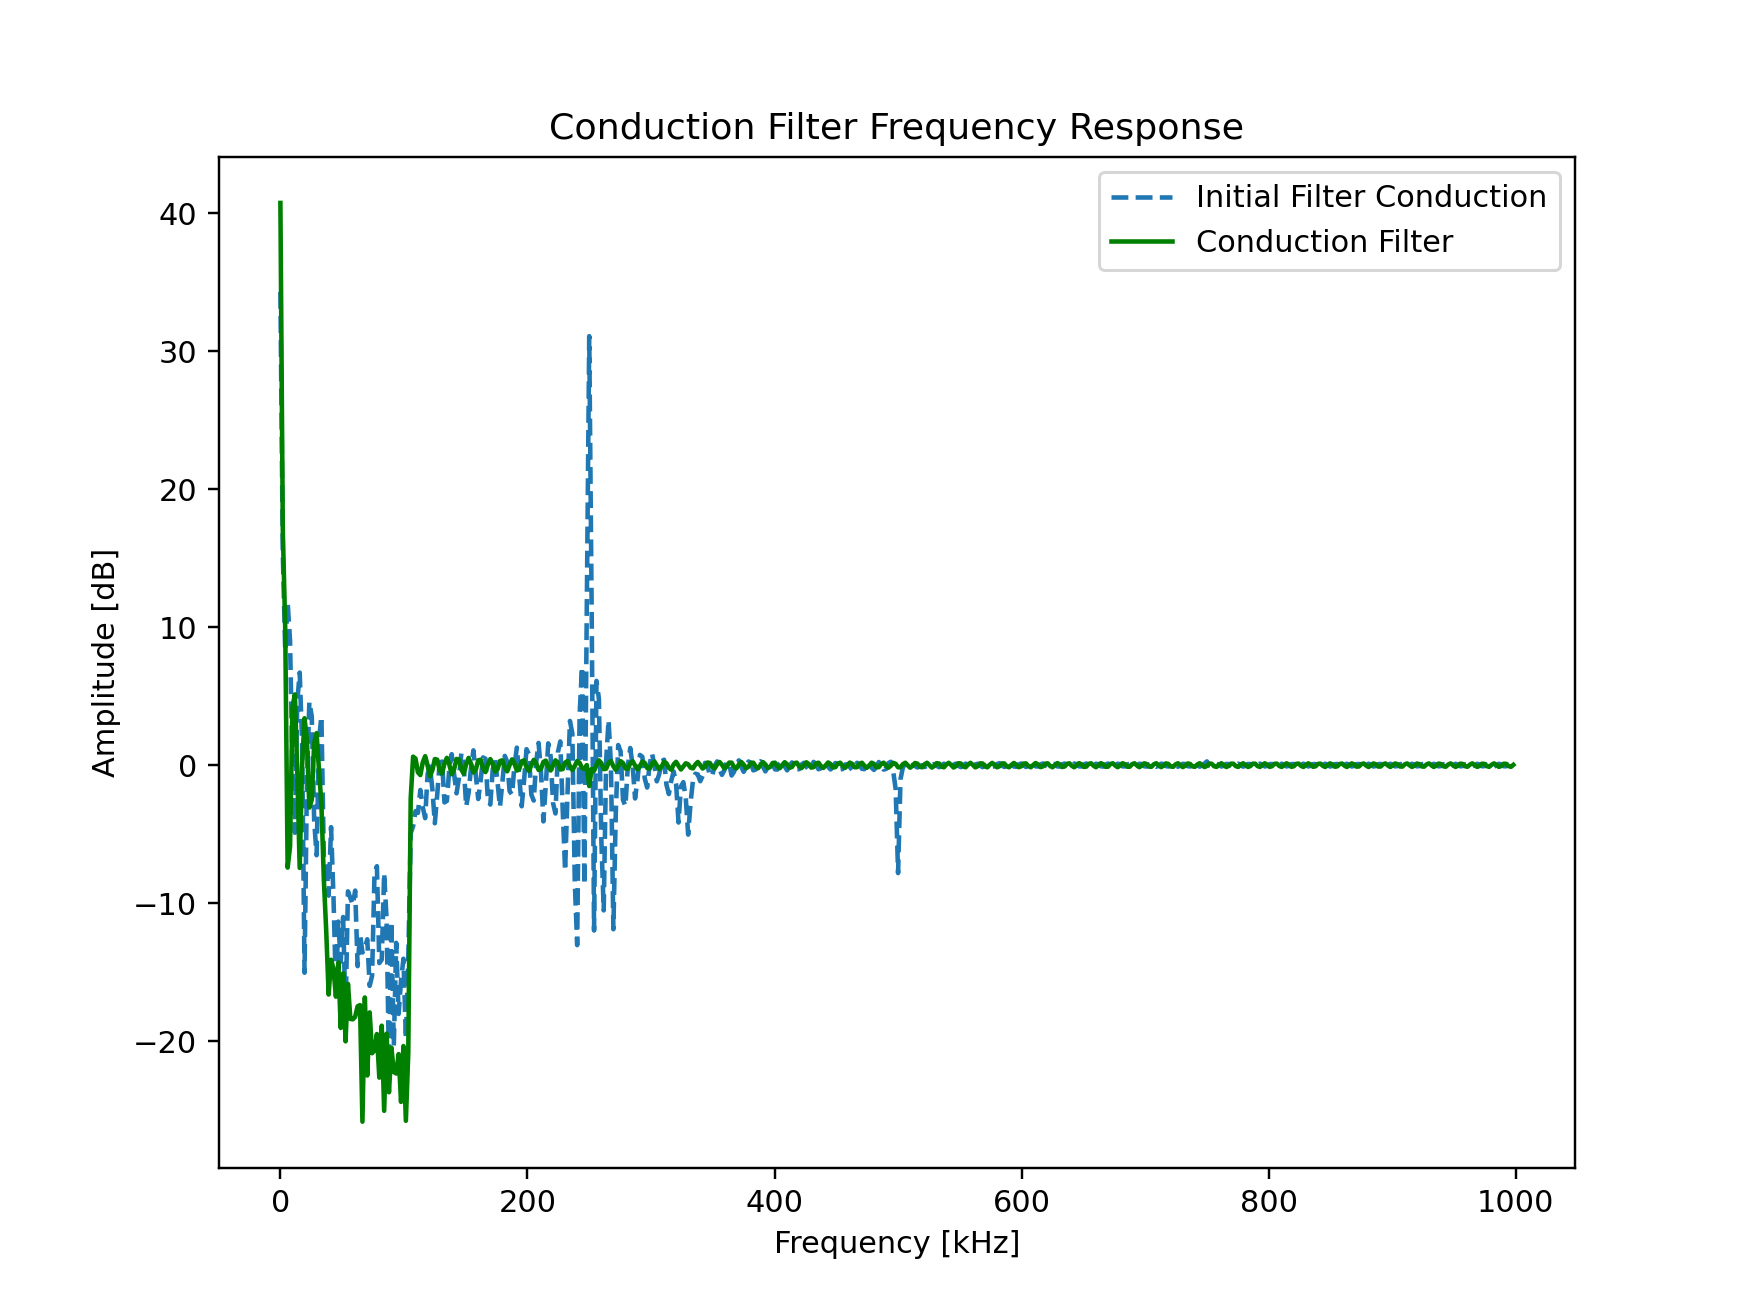

<IPython.core.display.Javascript object>


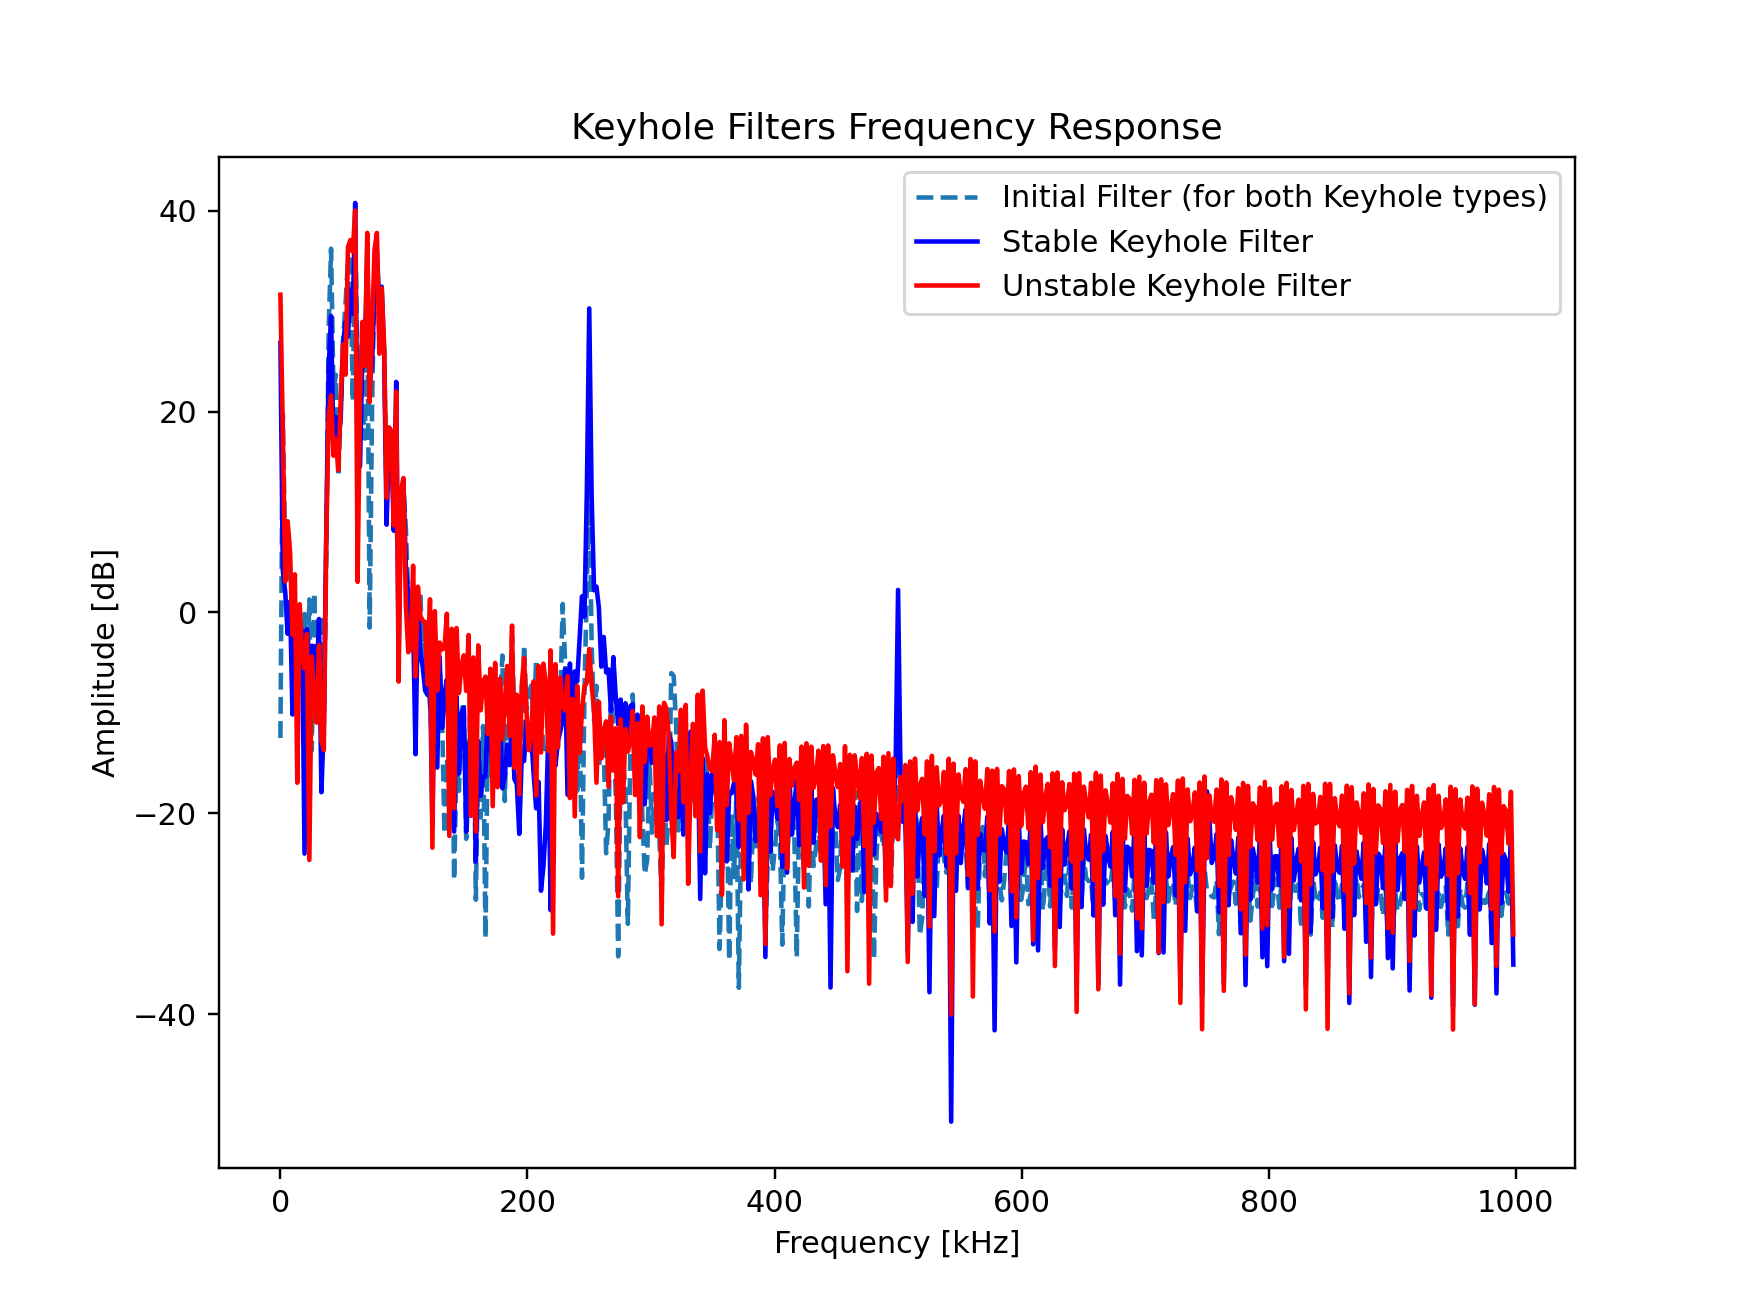

In [19]:
# Compute time array
num_samples = len(weigths_init)
time_array = np.linspace(0, num_samples / Fs, num_samples) * 1000  # in milliseconds

# Retrieve filter weights (impulse response) for the three models
weights_cond = prediction.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + prediction.smooth_filtKH.bias.cpu().detach().numpy()
weights_kh = predictionKH.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionKH.smooth_filtKH.bias.cpu().detach().numpy()
weights_unst = predictionUnst.smooth_filtKH.weight.view(-1).cpu().detach().numpy() + predictionUnst.smooth_filtKH.bias.cpu().detach().numpy()

# Compute frequency response for all filters
w_init_cond, h_init_cond = scipy.signal.freqz(weigths_init_cond, fs=Fs)
w_cond, h_cond = scipy.signal.freqz(weights_cond, fs=Fs)

w_init, h_init = scipy.signal.freqz(weigths_init, fs=Fs)
w_kh, h_kh = scipy.signal.freqz(weights_kh, fs=Fs)
w_unst, h_unst = scipy.signal.freqz(weights_unst, fs=Fs)

# Plot for Conduction filter's frequency response
plt.figure(figsize=(8, 6))
plt.plot(w_init_cond/1e3, 20 * np.log10(abs(h_init_cond)), label='Initial Filter Conduction', linestyle='--')
plt.plot(w_cond/1e3, 20 * np.log10(abs(h_cond)), label='Conduction Filter', color='green')
plt.legend()
plt.title('Conduction Filter Frequency Response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.show()

# Plot for Keyhole filters' frequency response
plt.figure(figsize=(8, 6))
plt.plot(w_init/1e3, 20 * np.log10(abs(h_init)), label='Initial Filter (for both Keyhole types)', linestyle='--')
plt.plot(w_kh/1e3, 20 * np.log10(abs(h_kh)), label='Stable Keyhole Filter', color='blue')
plt.plot(w_unst/1e3, 20 * np.log10(abs(h_unst)), label='Unstable Keyhole Filter', color='red')
plt.legend()
plt.title('Keyhole Filters Frequency Response')
plt.xlabel('Frequency [kHz]')
plt.ylabel('Amplitude [dB]')
plt.show()


### Frequency Response Visualization for Multiple Models using LOOCV

In this section, we're visualizing the frequency responses of the Stable Keyhole filters obtained from various models trained using the Leave-One-Out Cross-Validation (LOOCV) approach. Due to the LOOCV method, we end up with as many trained models as there are signals in our dataset. Each iteration of LOOCV retains a single data sample as the validation set while training on the rest, resulting in a distinct model for each signal. 

The plotted frequency responses allow us to inspect the spectral characteristics of the Keyhole filters for each of these models. By analyzing these plots, we can gain insights into the consistency and variability of the filter behavior across different LOOCV iterations.


<IPython.core.display.Javascript object>


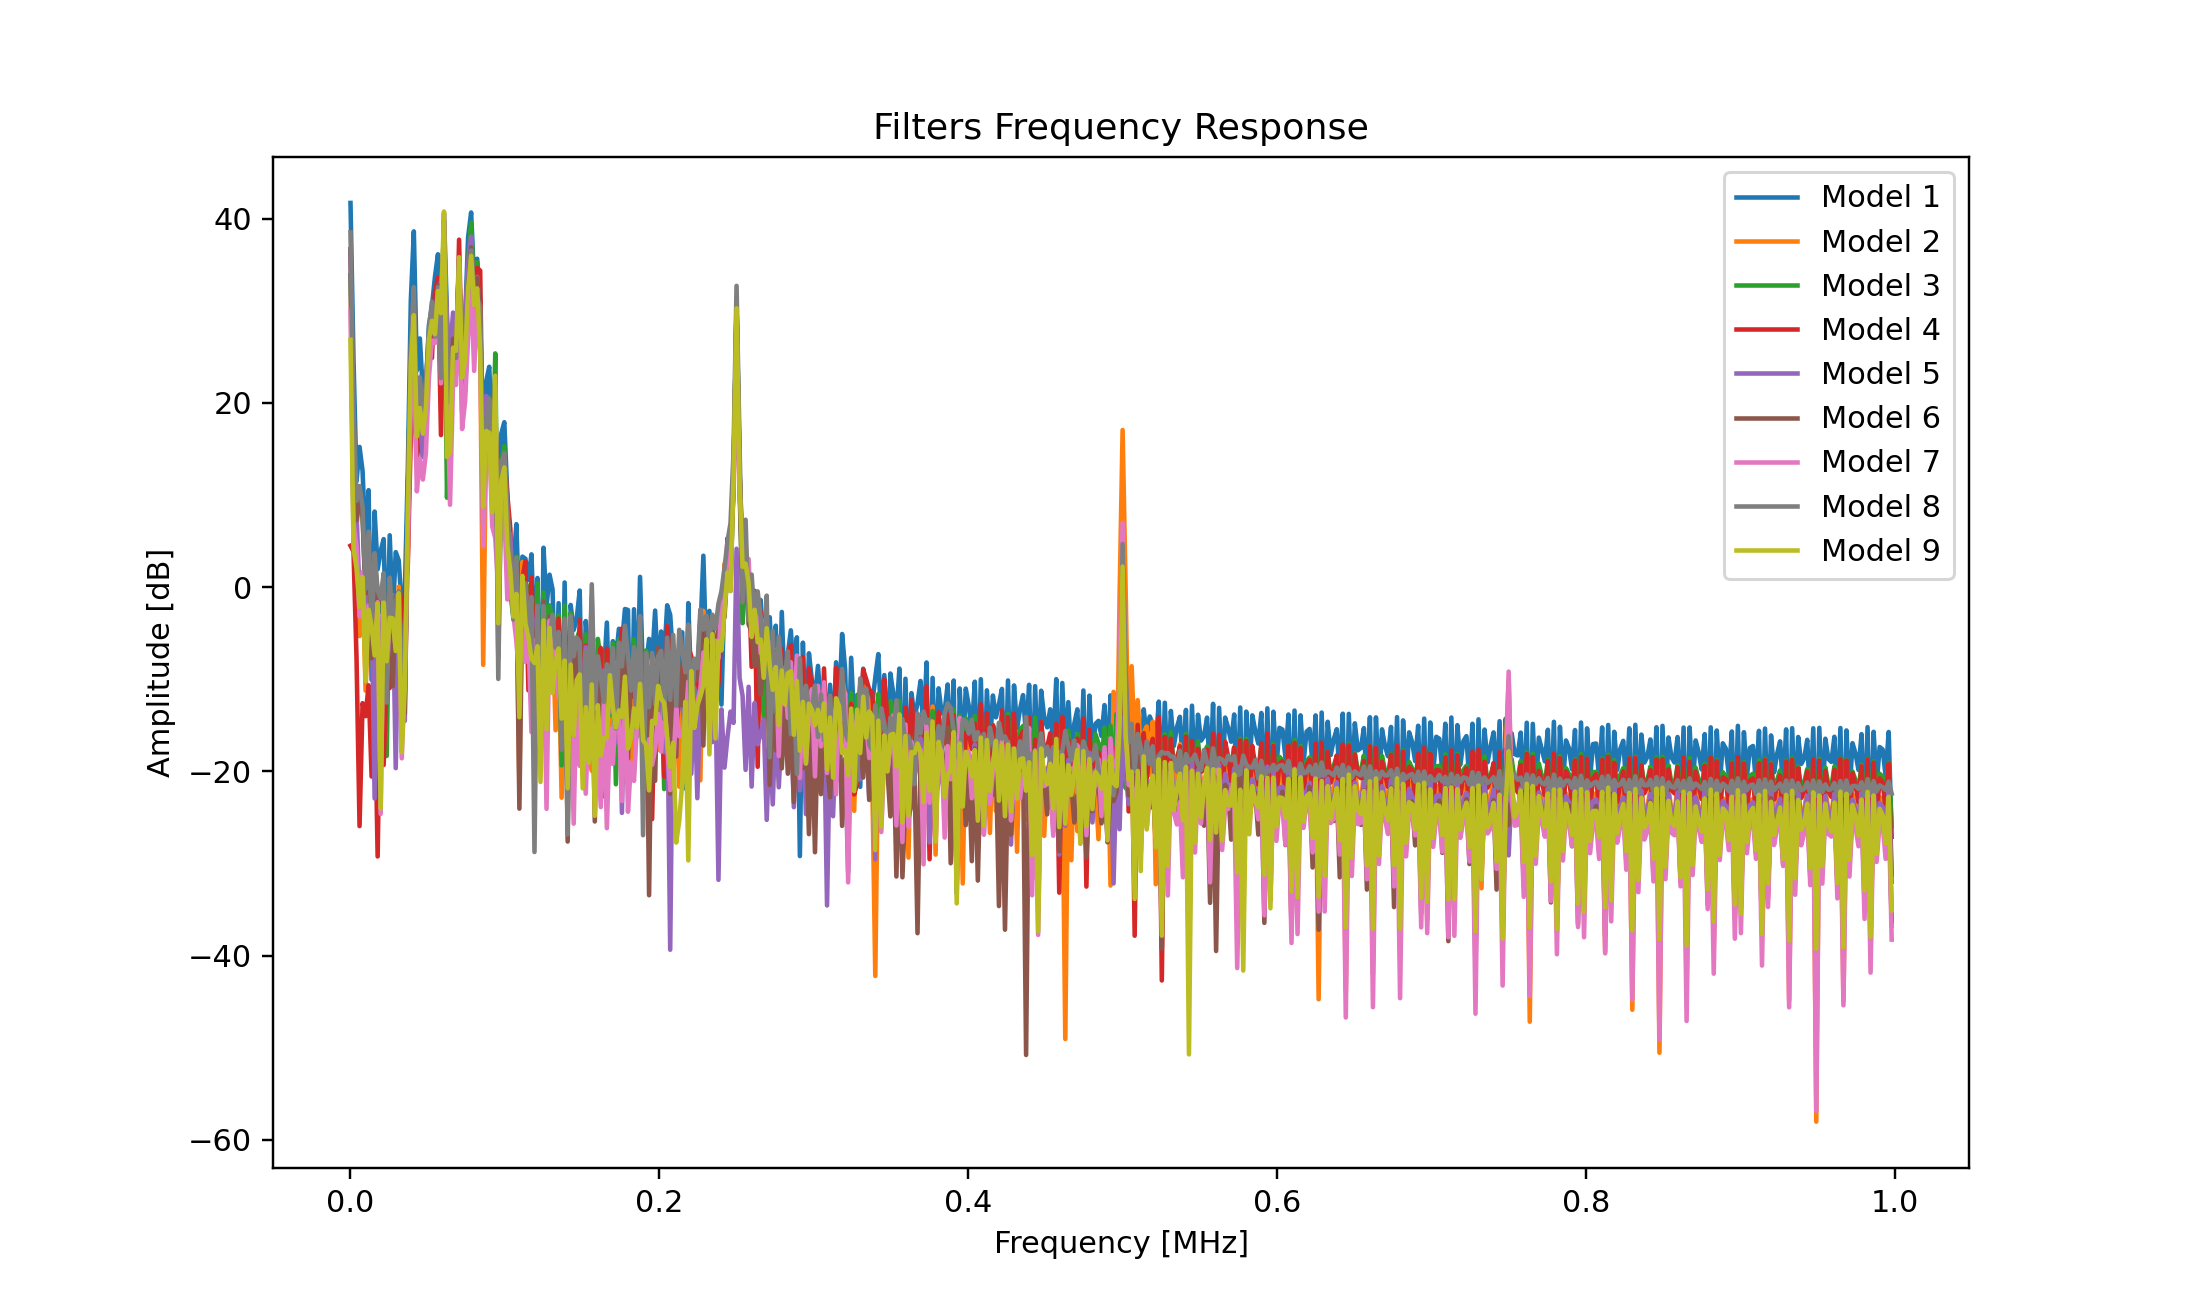

In [21]:
# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over all models in models_KH
for i in range(len(xs)):
    # Extract filter from the model
    predictionKH = models_KH[i]
    weights_starKH = predictionKH.smooth_filtKH.weight.view(-1).to('cpu').detach().numpy() + predictionKH.smooth_filtKH.bias.view(-1).to('cpu').detach().numpy()
    
    # Compute frequency response for the Stable Keyhole filter
    w_KH, h_KH = scipy.signal.freqz(weights_starKH, fs=Fs)

    # Plotting
    plt.title(f'Filters Frequency Response')
    plt.plot(w_KH / 1e6, 20 * np.log10(np.abs(h_KH)), label=f'Model {i+1}')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [dB]')
    plt.legend()
    plt.show()


### Model Evaluation and Visualization for Three Regimes Using LOOCV

In this evaluation, we leverage the Leave-One-Out Cross-Validation (LOOCV) method to assess the model's performance on each available signal in the dataset. The methodology involves:

1. **Data Preparation and Signal Processing:** For every signal in the dataset, the corresponding predictions from the trained models for the three regimes — Conduction, Stable Keyhole, and Unstable Keyhole — are extracted. Each signal is passed through every model, and the outputs are aggregated.
2. **Visualization:** The processed signals are graphically represented, juxtaposing the model's predictions against the ground truth. This visualization facilitates a visual assessment of the model's accuracy and highlights potential discrepancies.
3. **Metric Calculation:** For every signal, key performance metrics — F1-score, Precision, and Recall — are determined for each regime, providing a quantitative measure of the model's performance.
4. **Overall Evaluation:** Upon processing all signals, a comprehensive performance metric is derived, offering a holistic overview of the model's performance across the entire dataset.

Thanks to the LOOCV strategy, we ensure that each signal is treated as unseen data at least once, providing a robust evaluation of our model's generalization capabilities across the entire dataset.


<IPython.core.display.Javascript object>


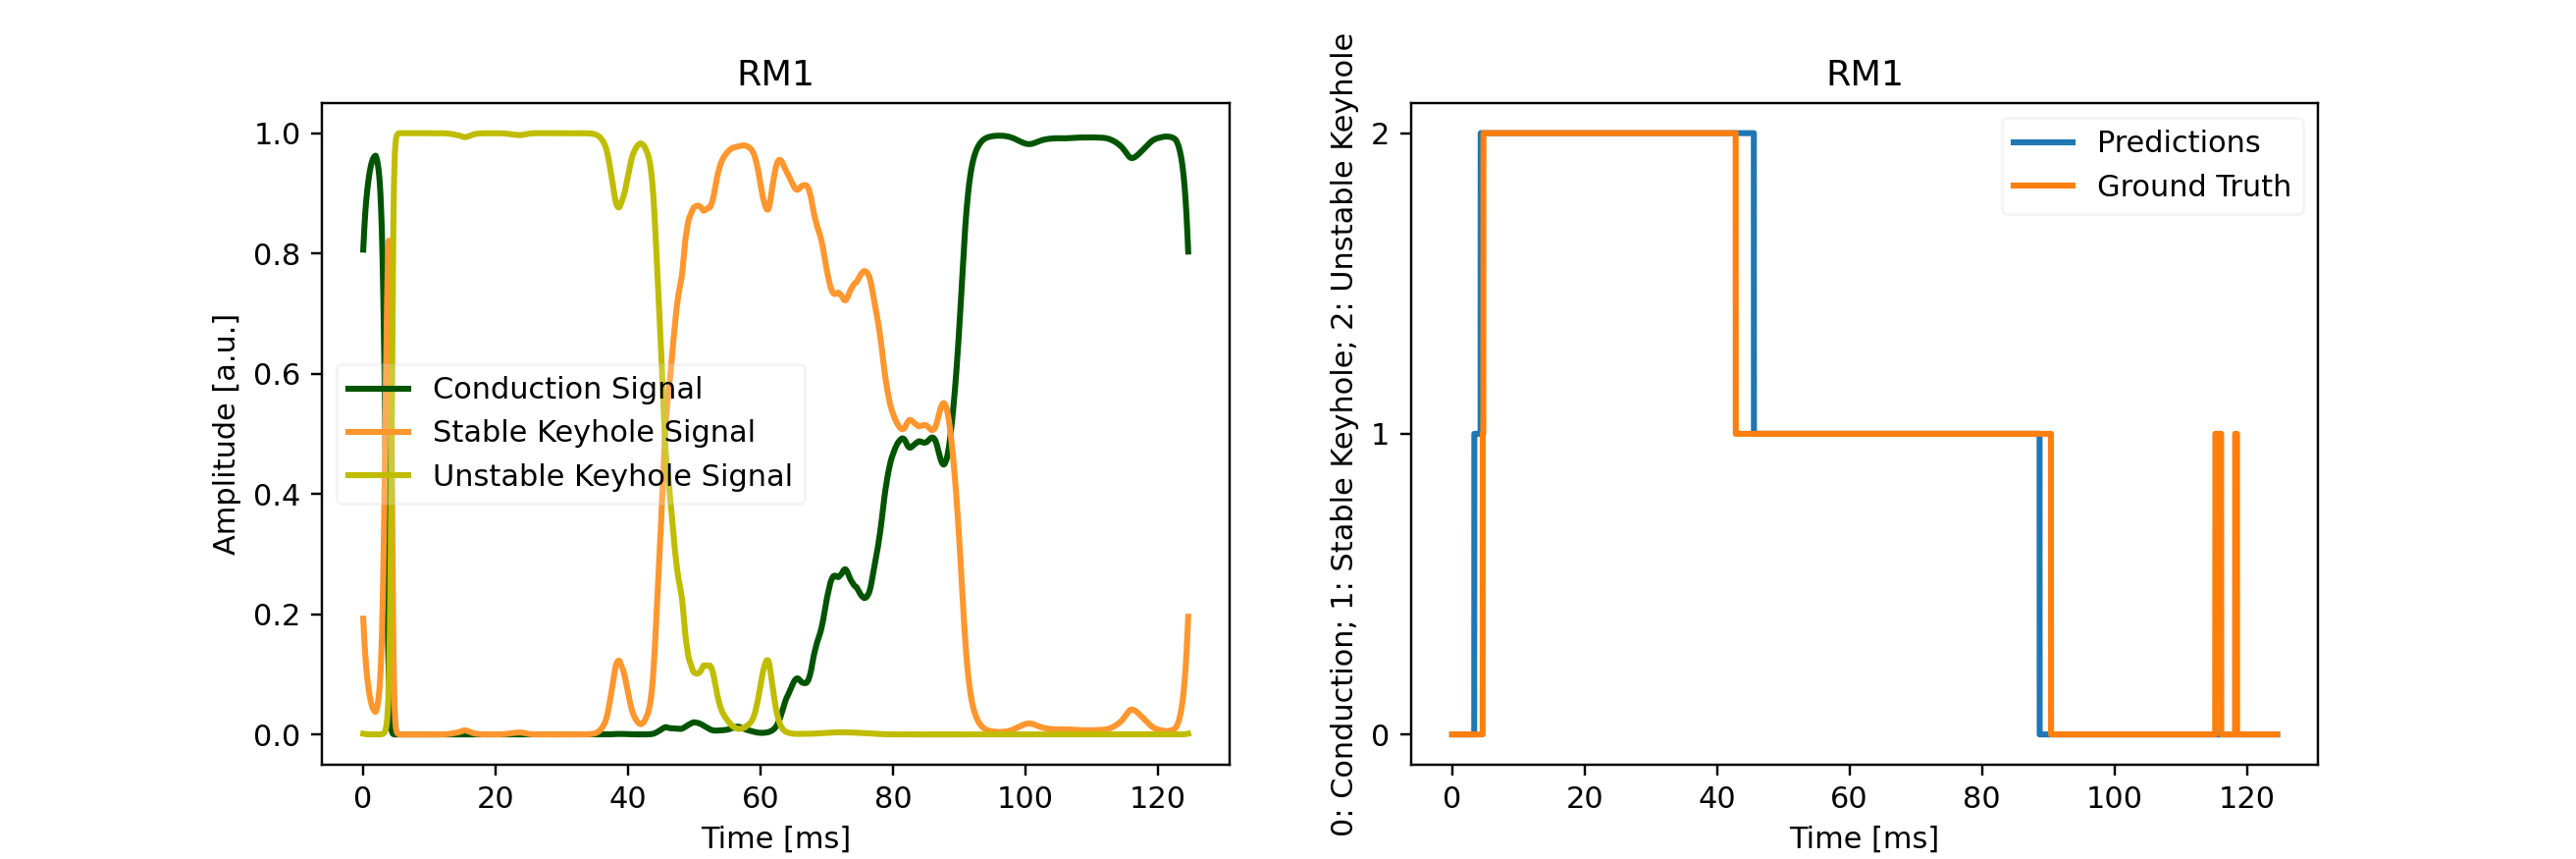

----------------------------------------------------------------------------------------------------


/tmp/ipykernel_20978/1347101086.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


<IPython.core.display.Javascript object>


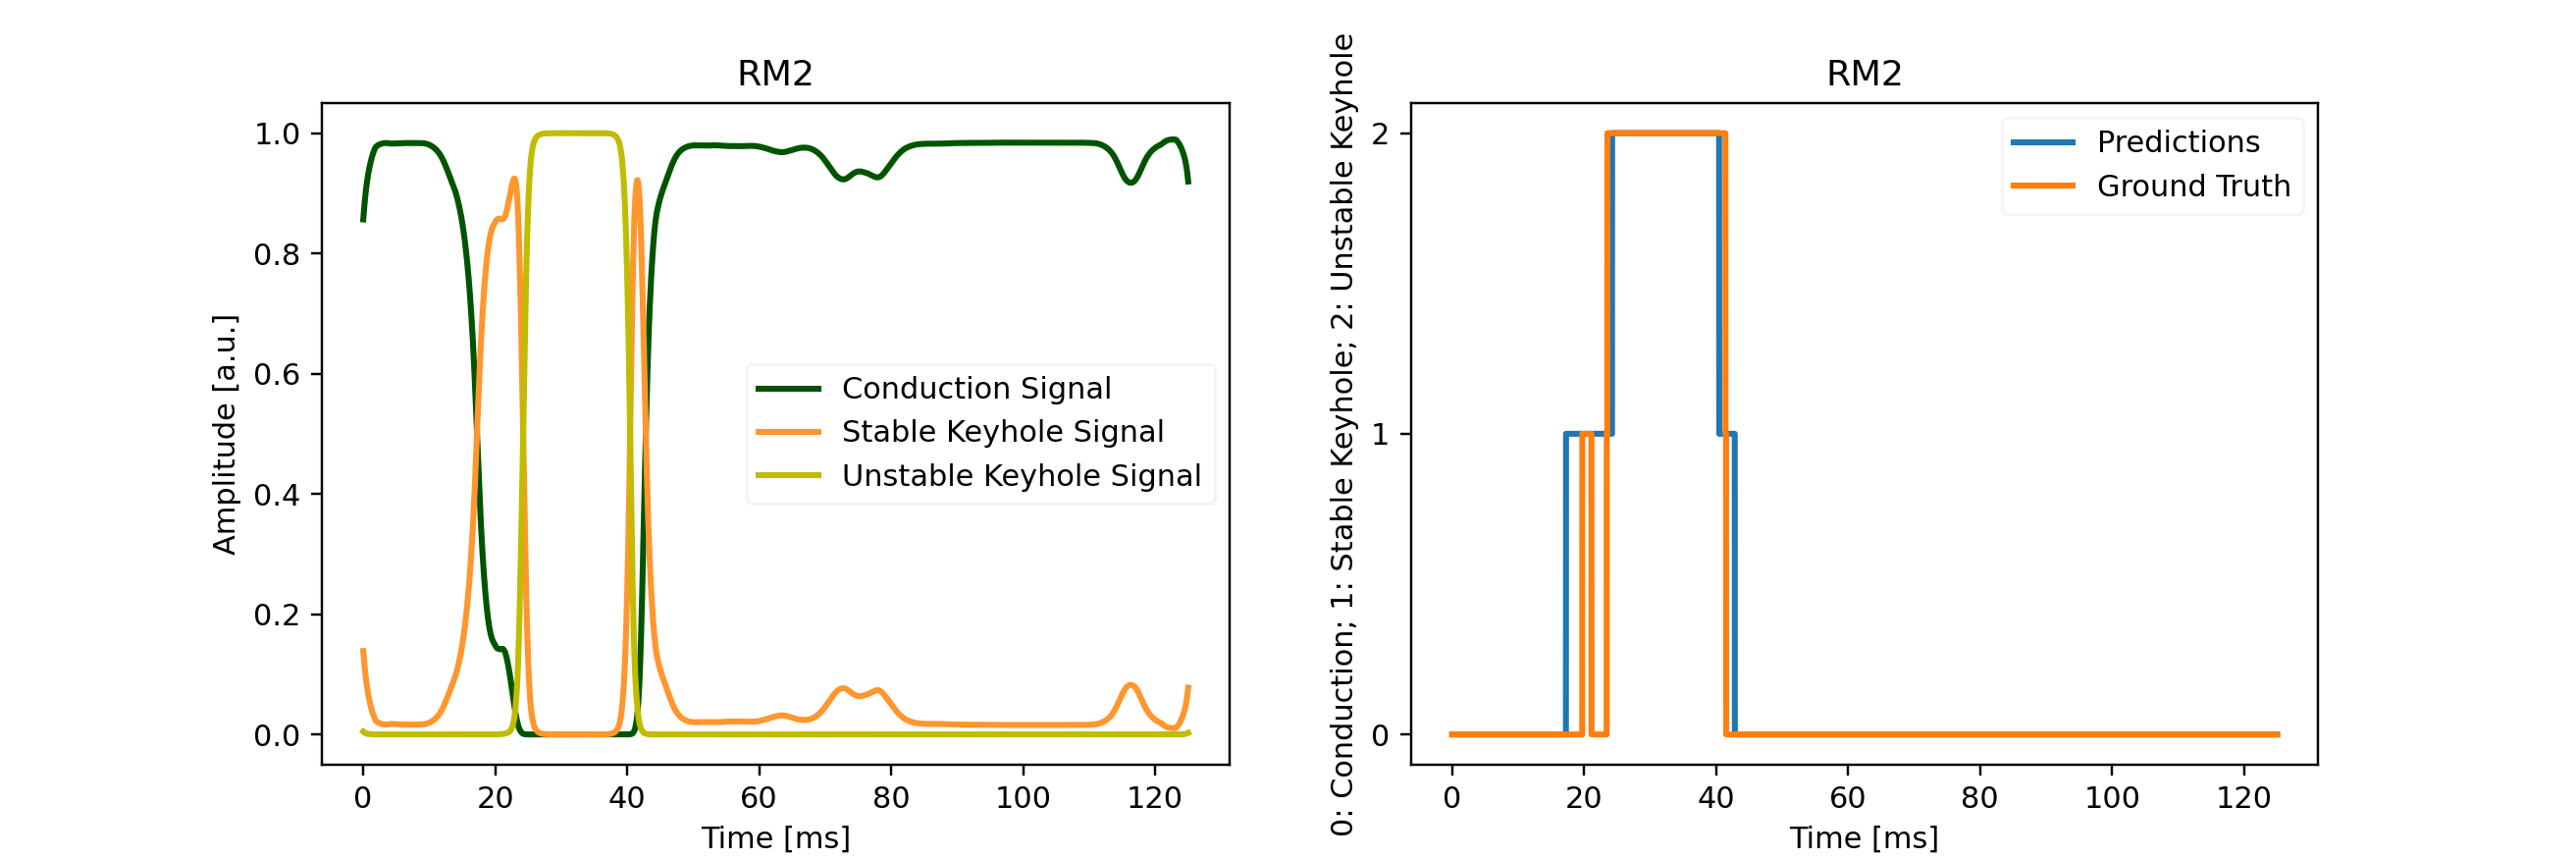

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


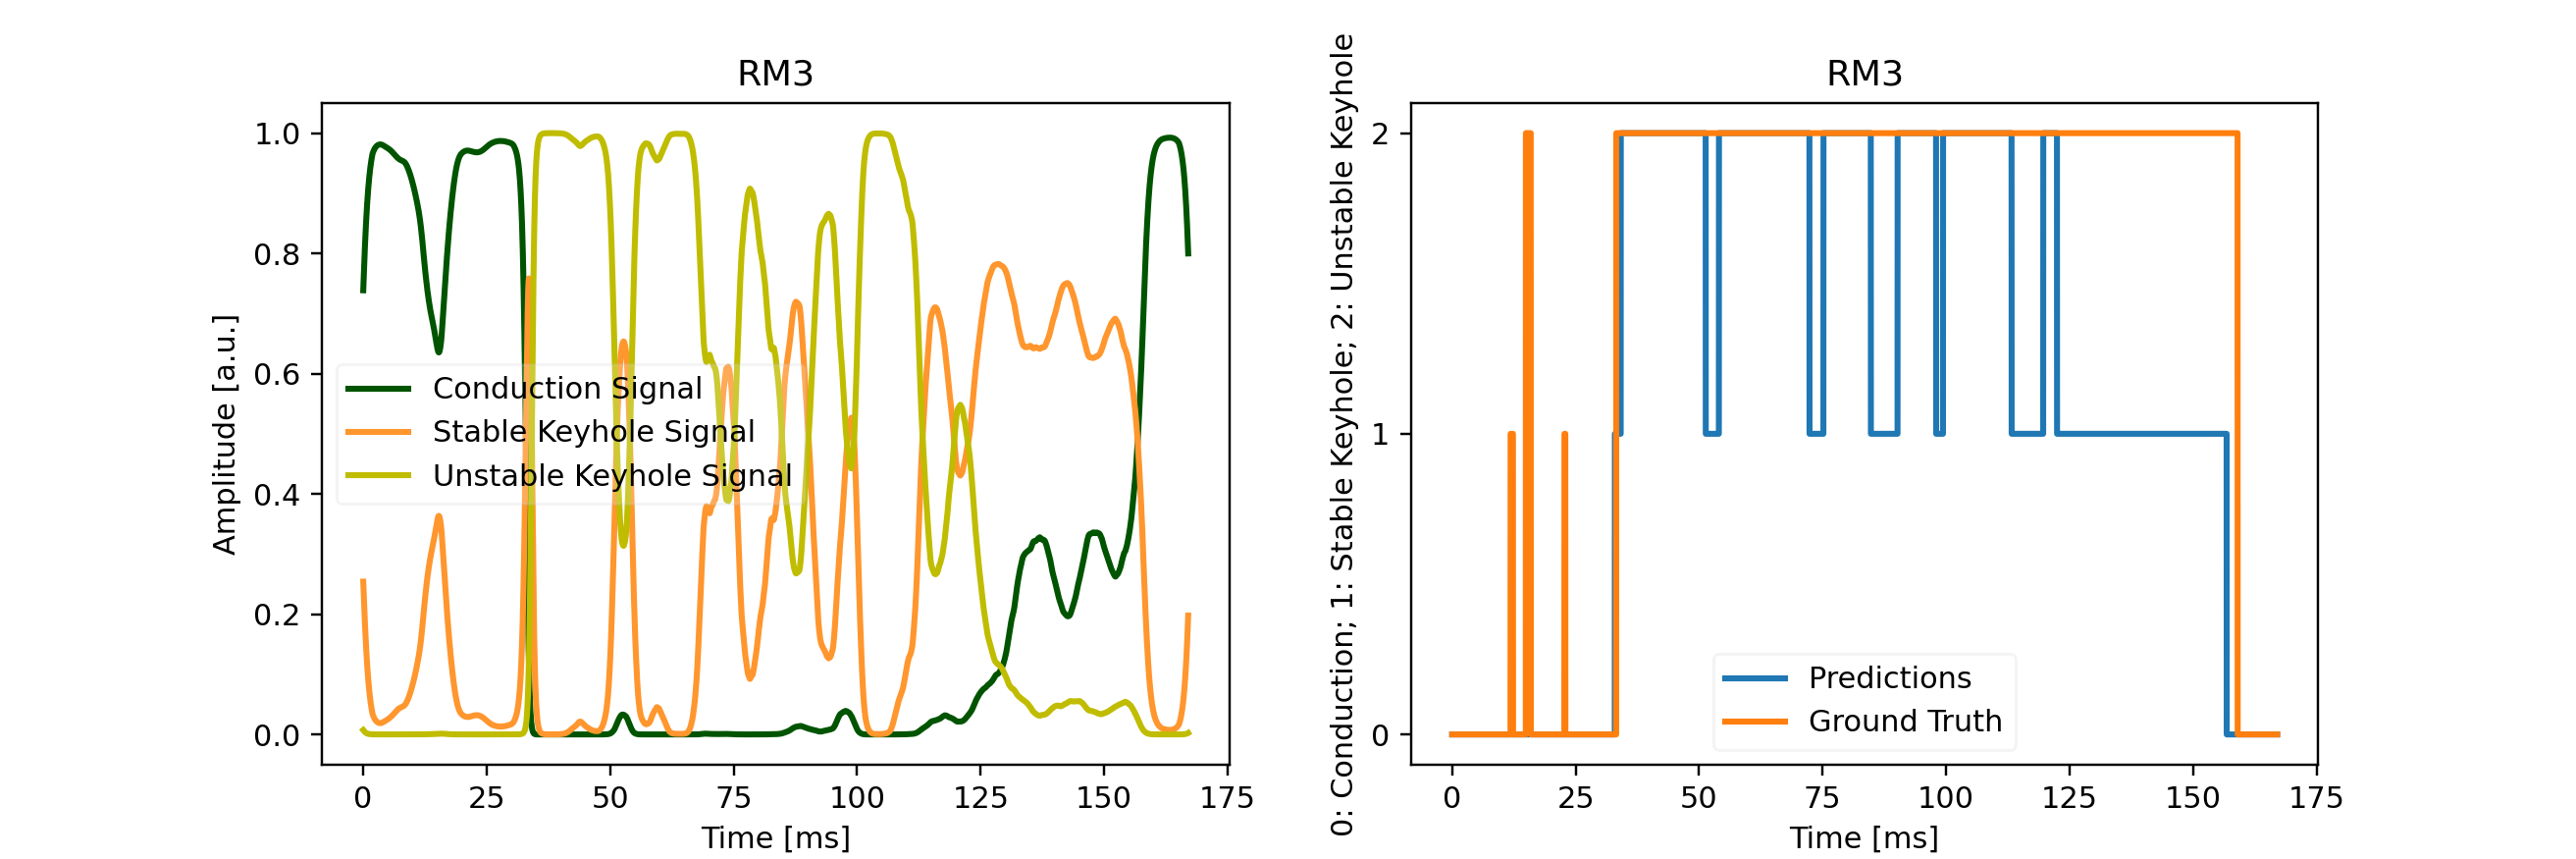

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


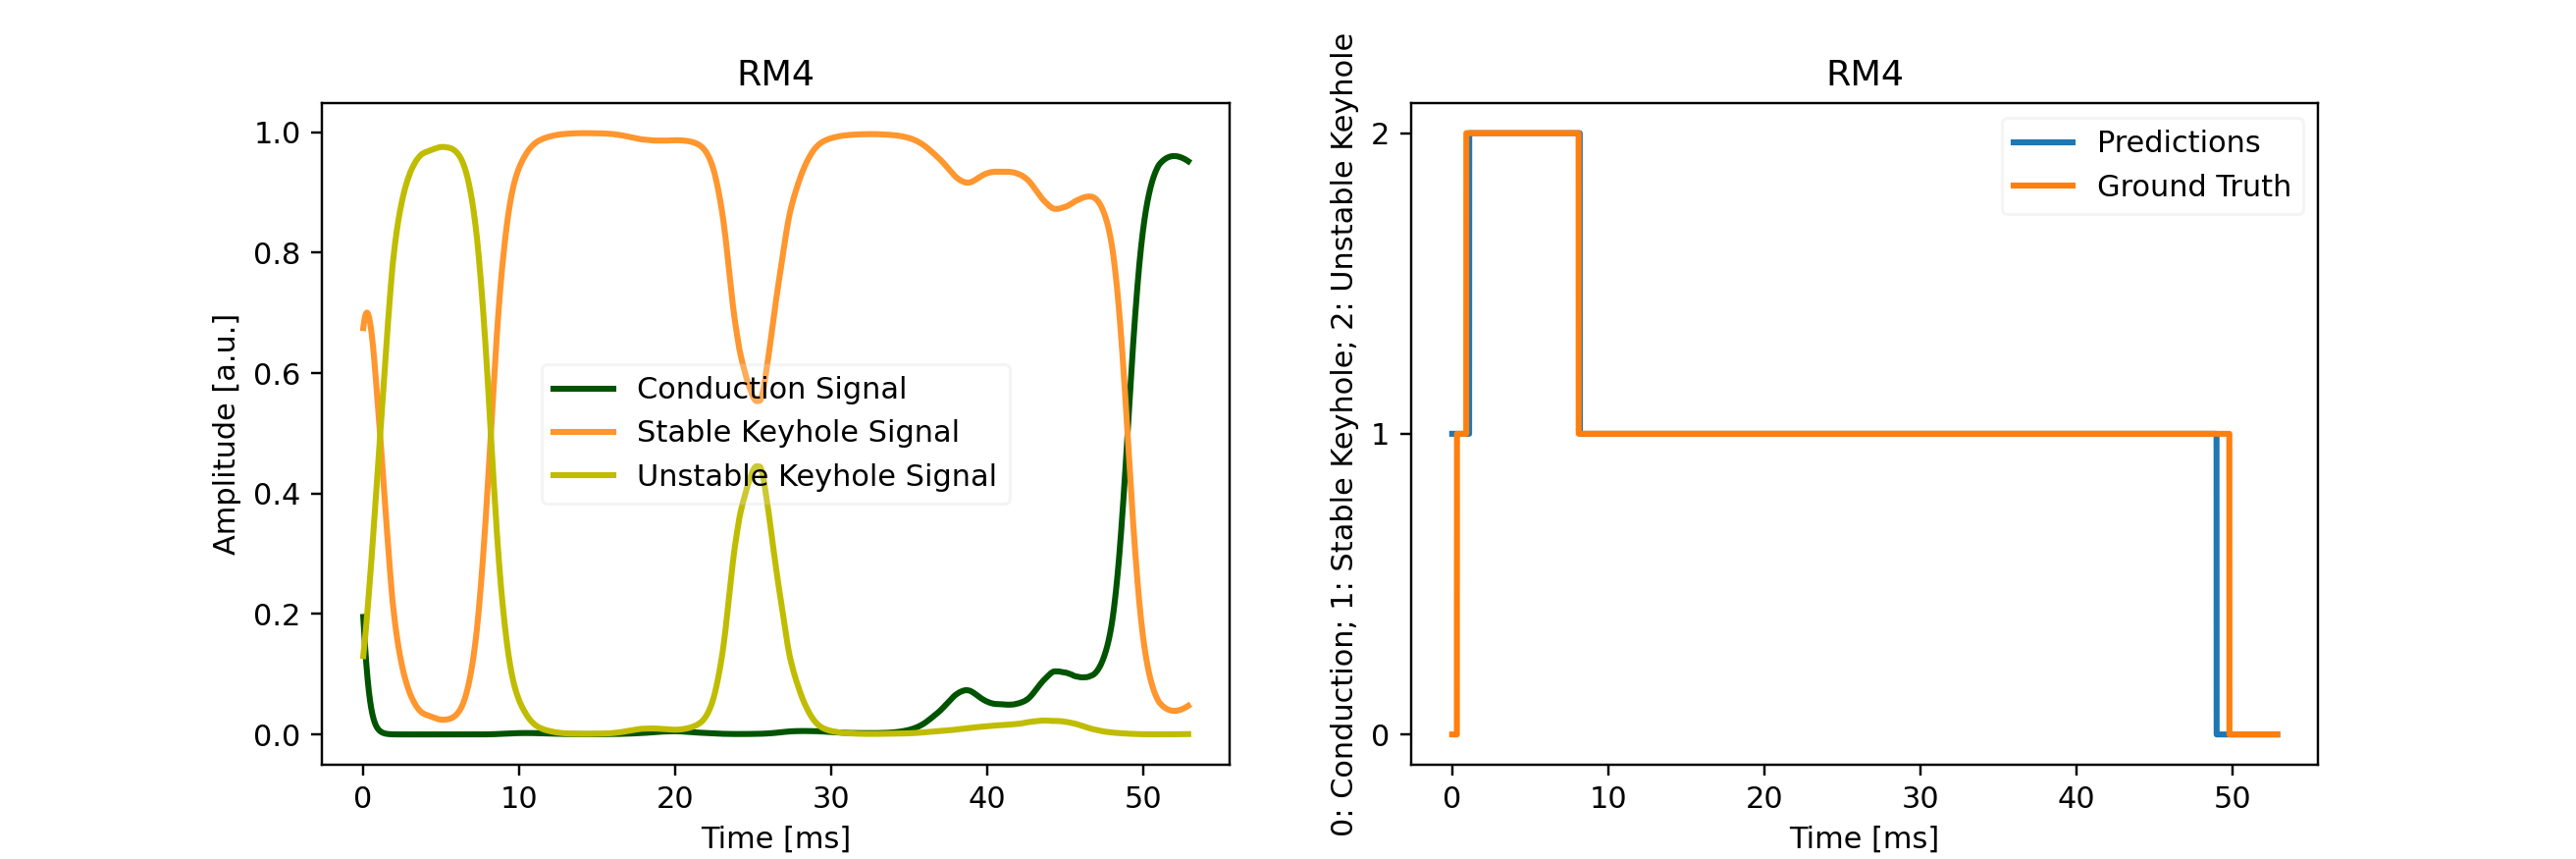

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


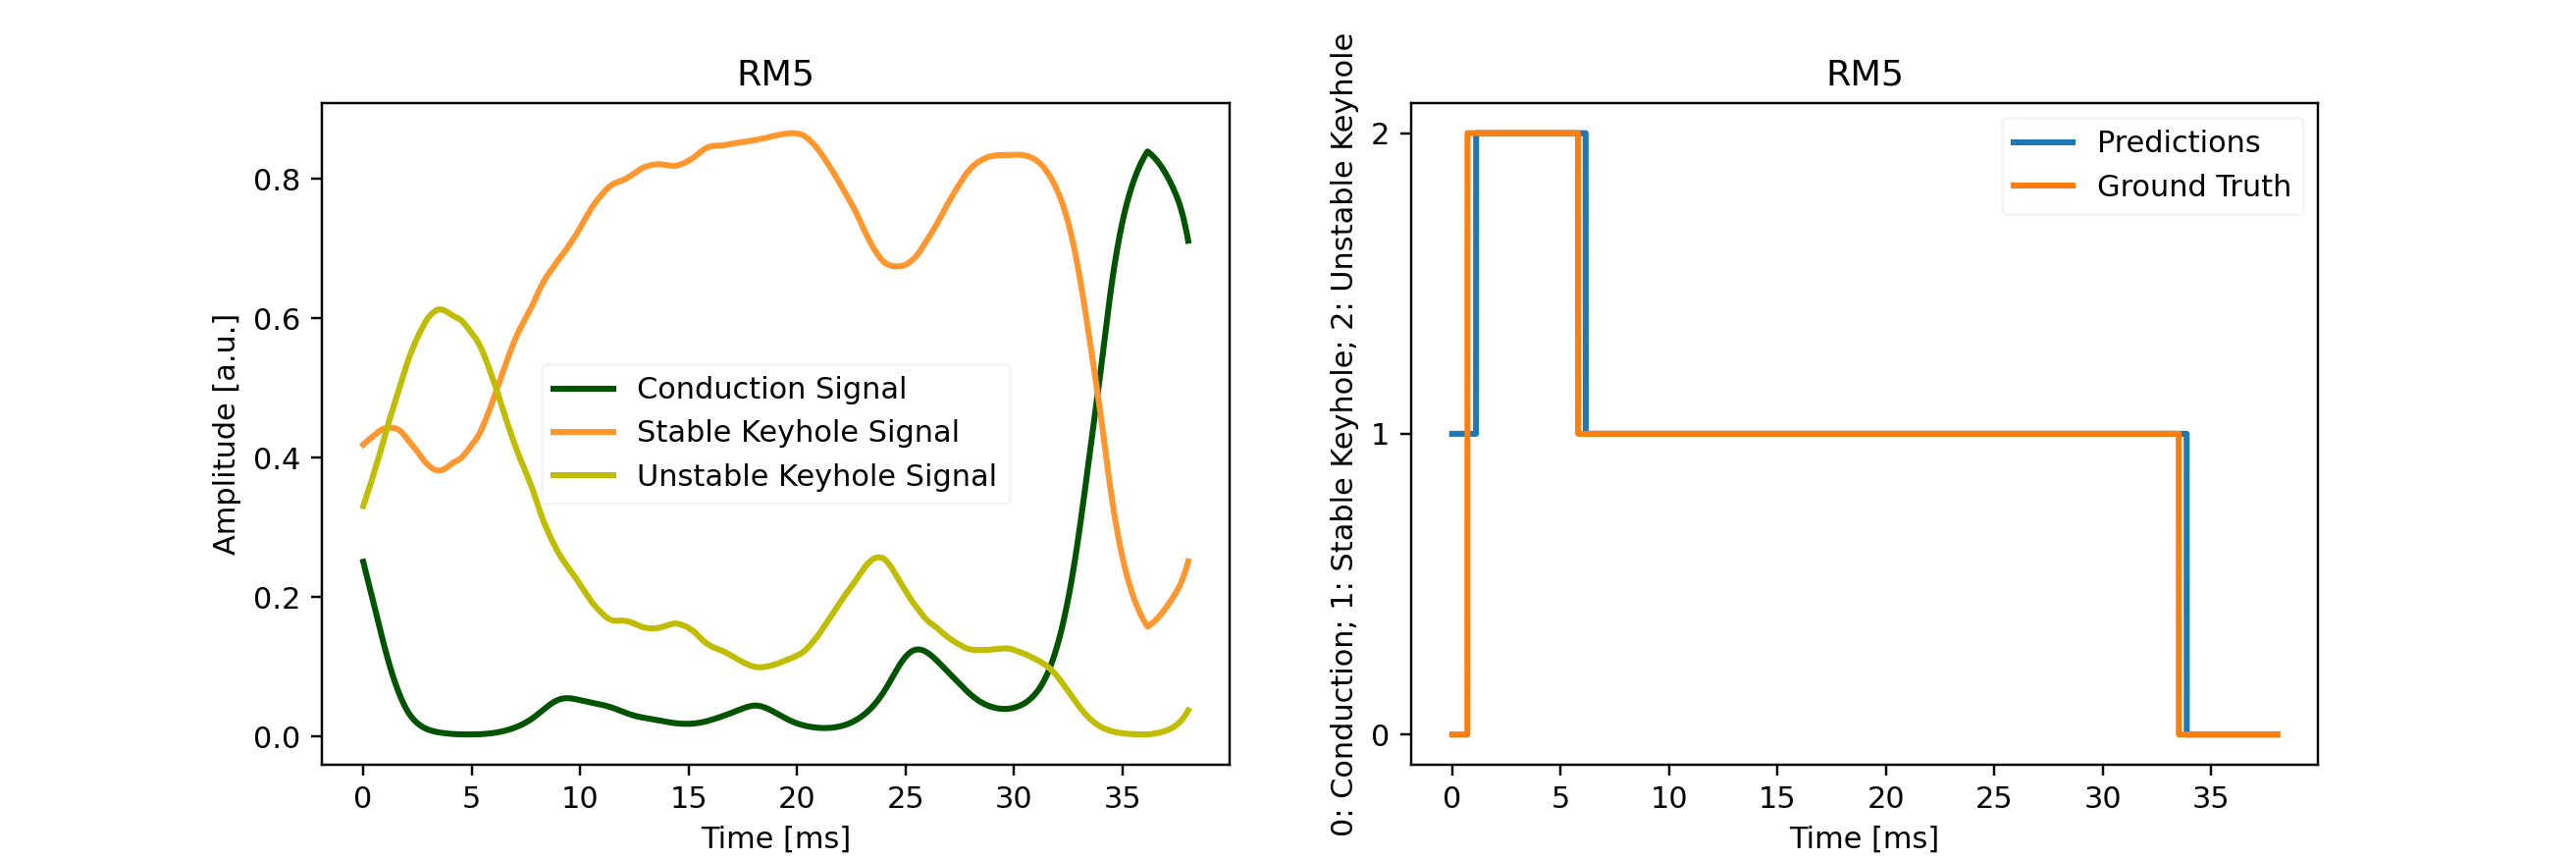

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


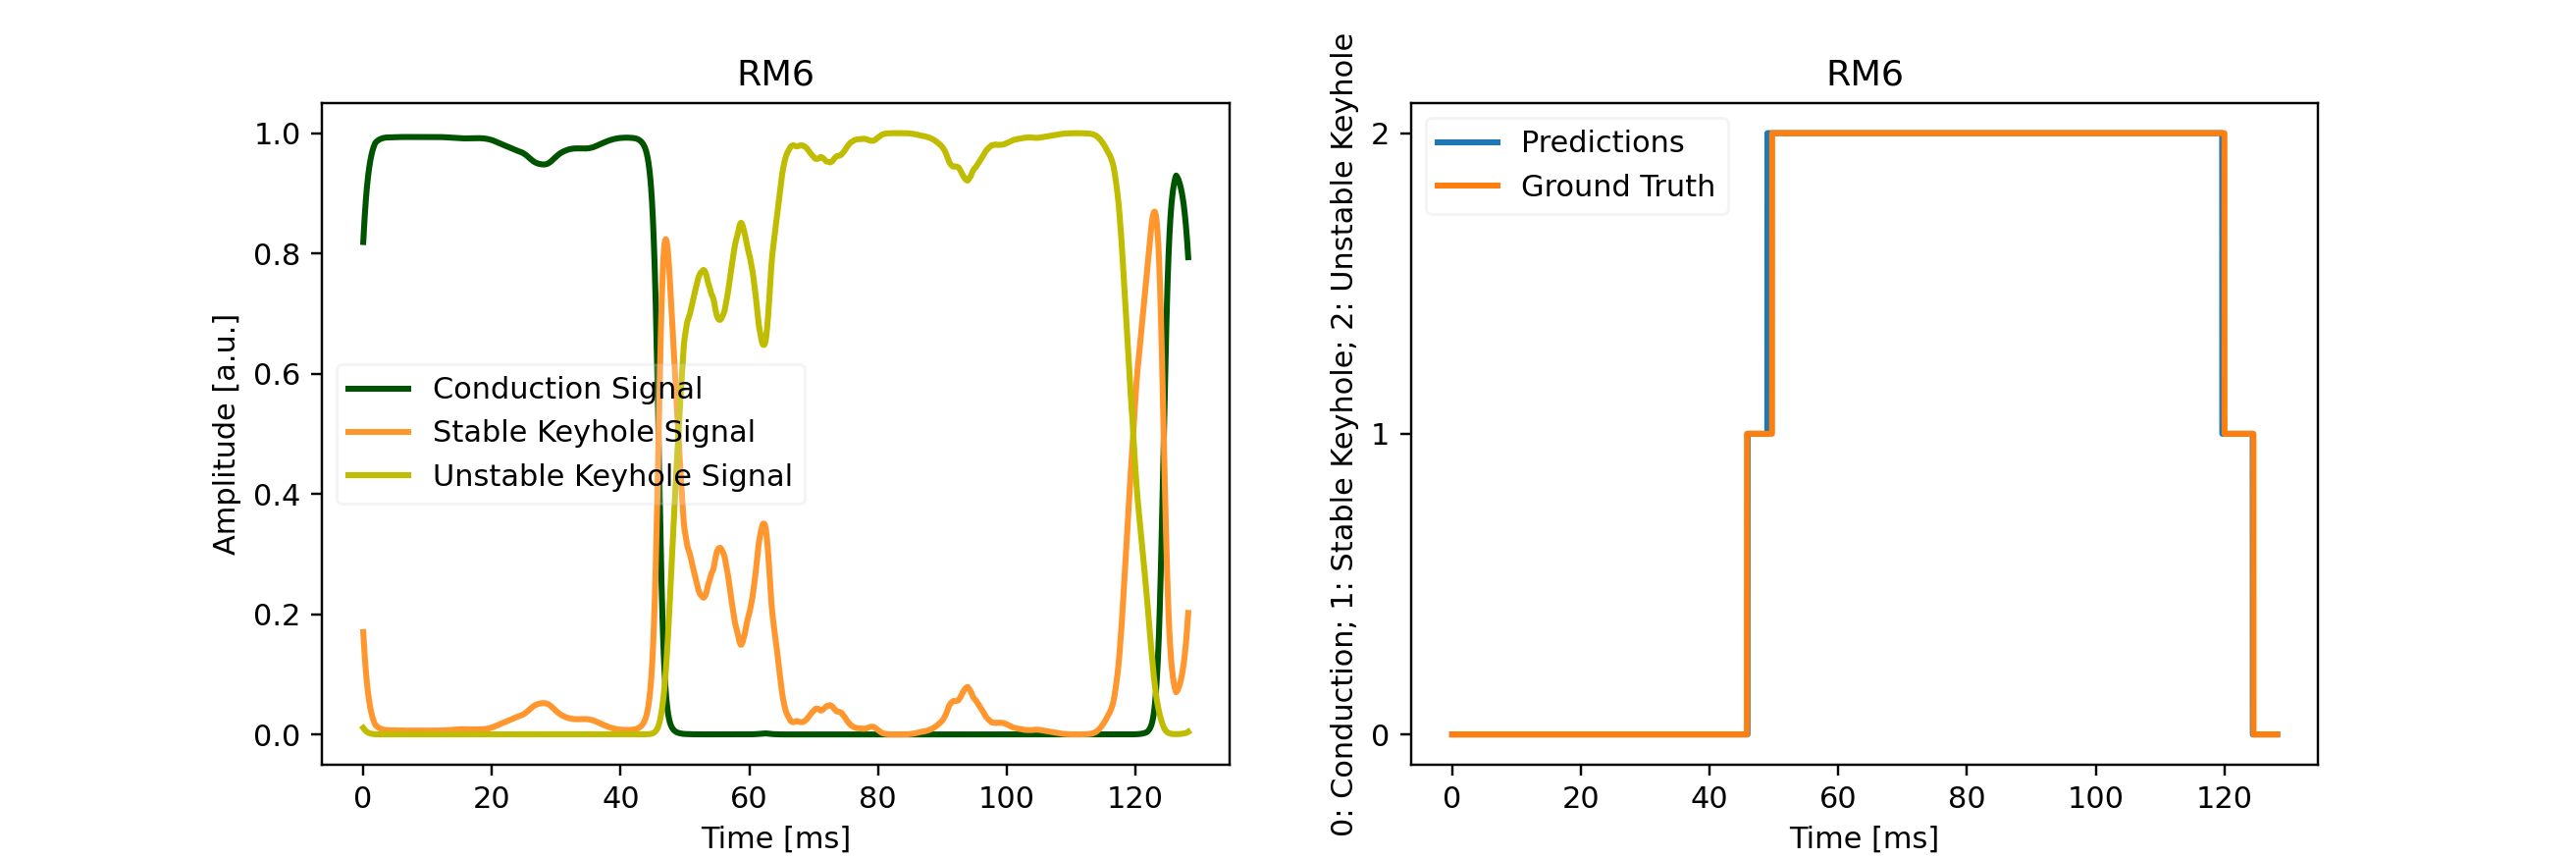

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


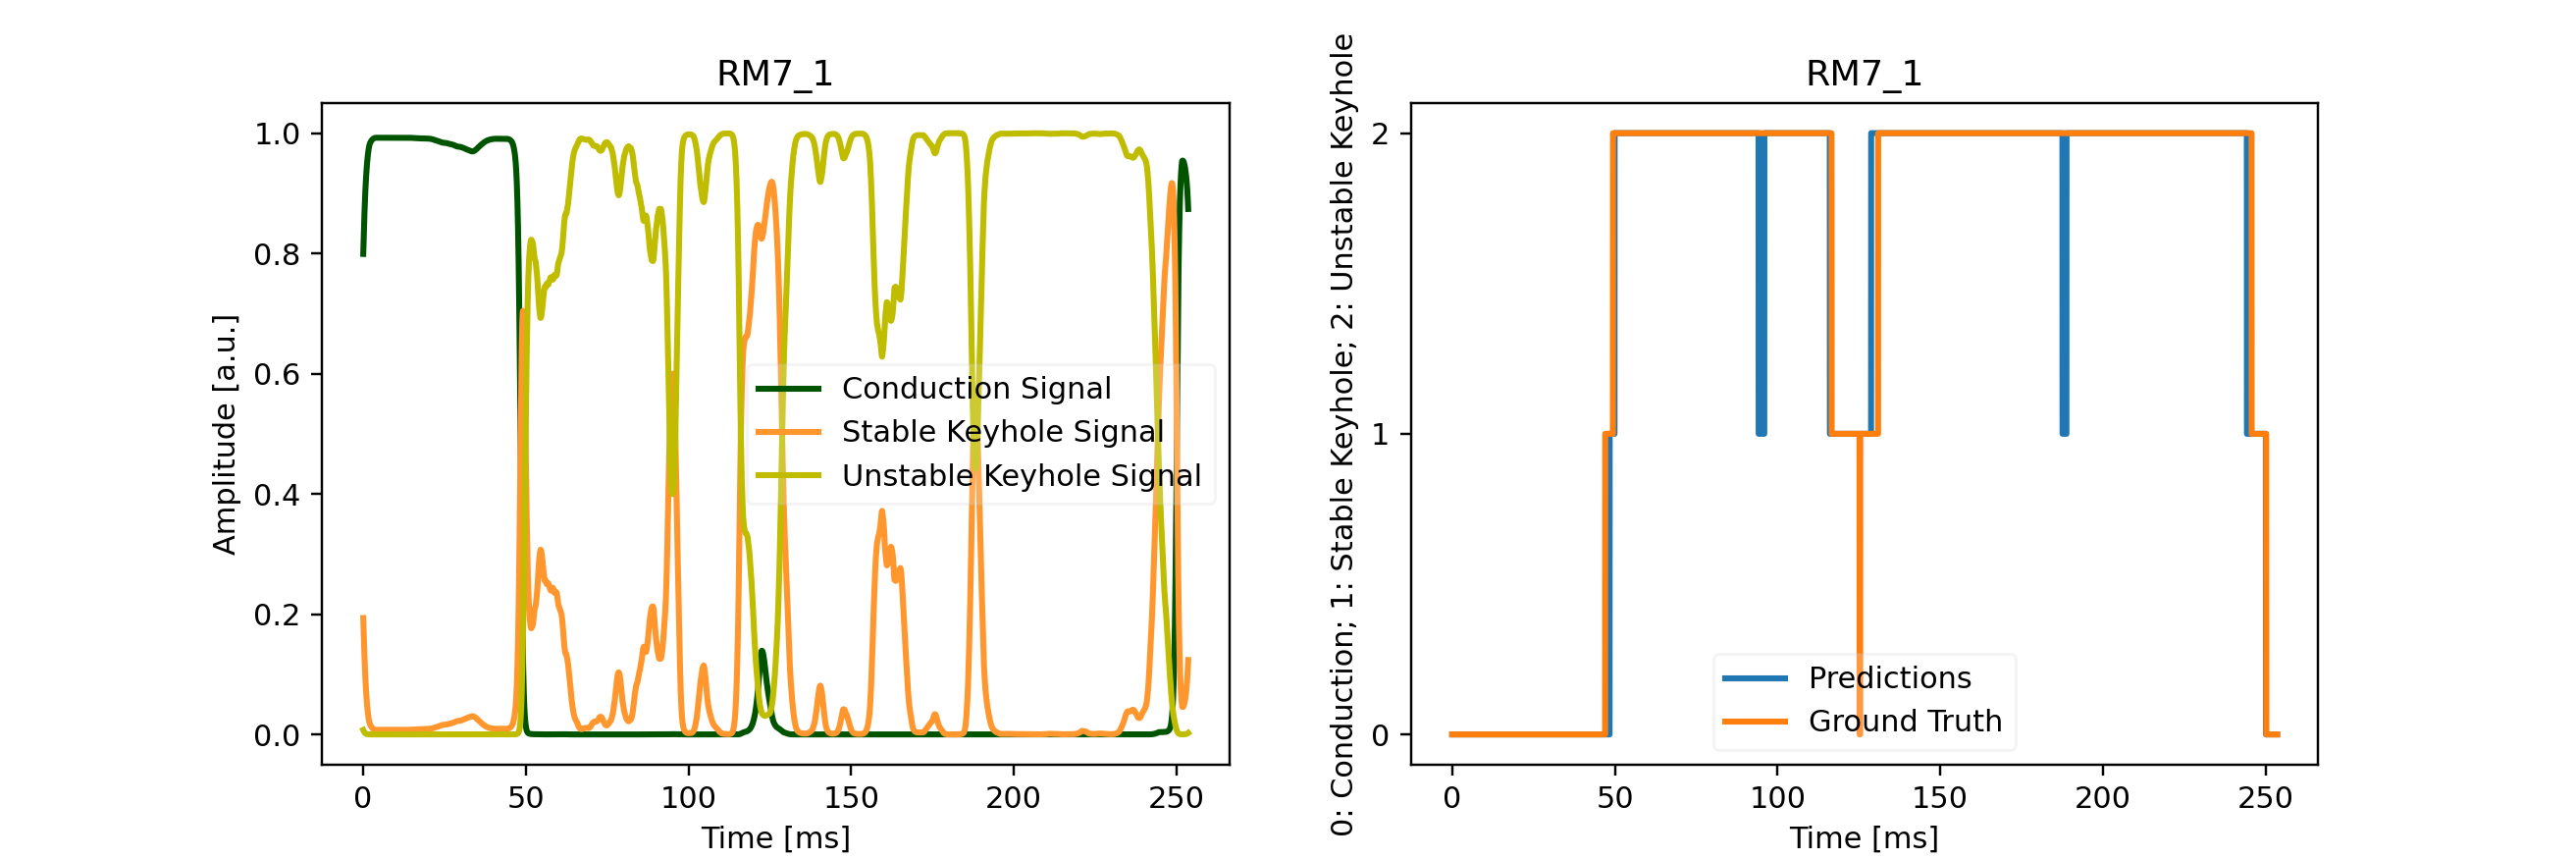

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


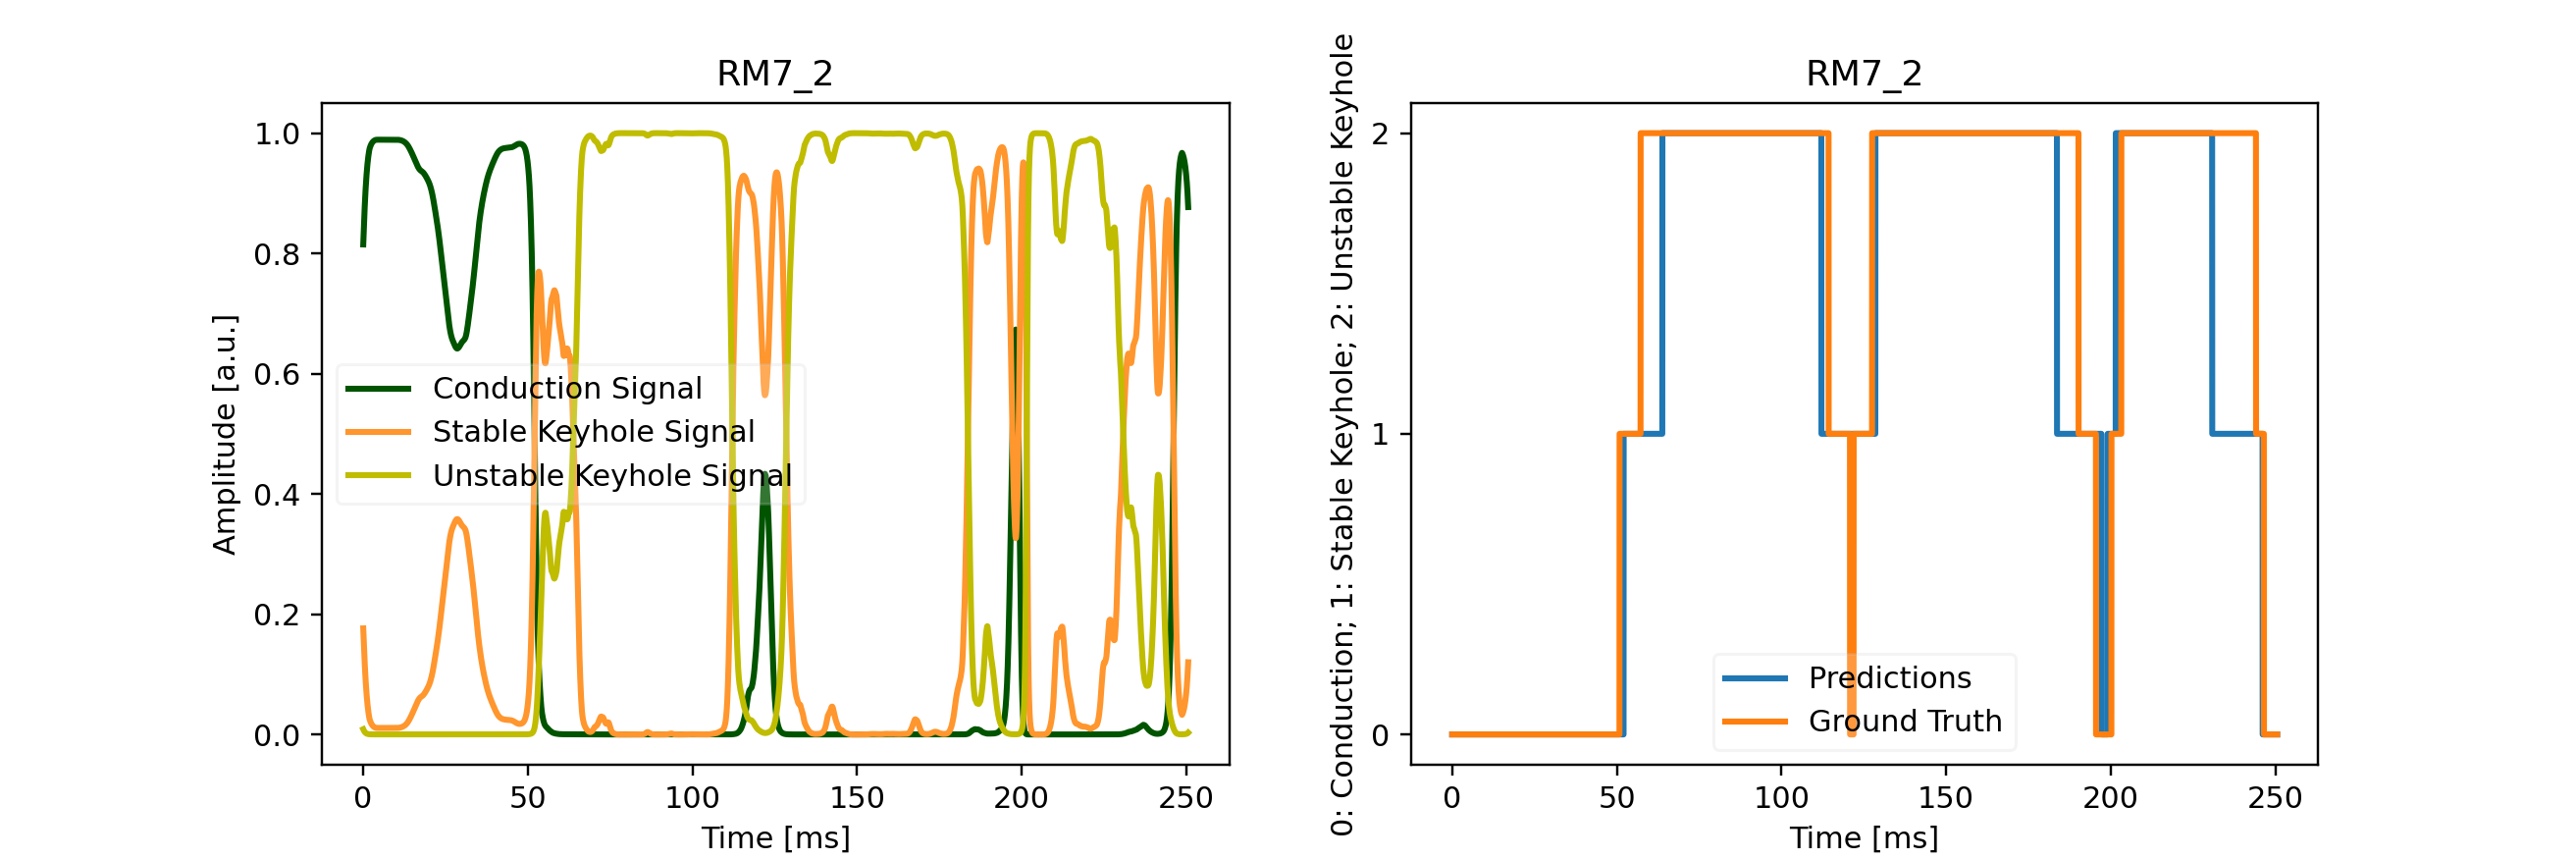

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


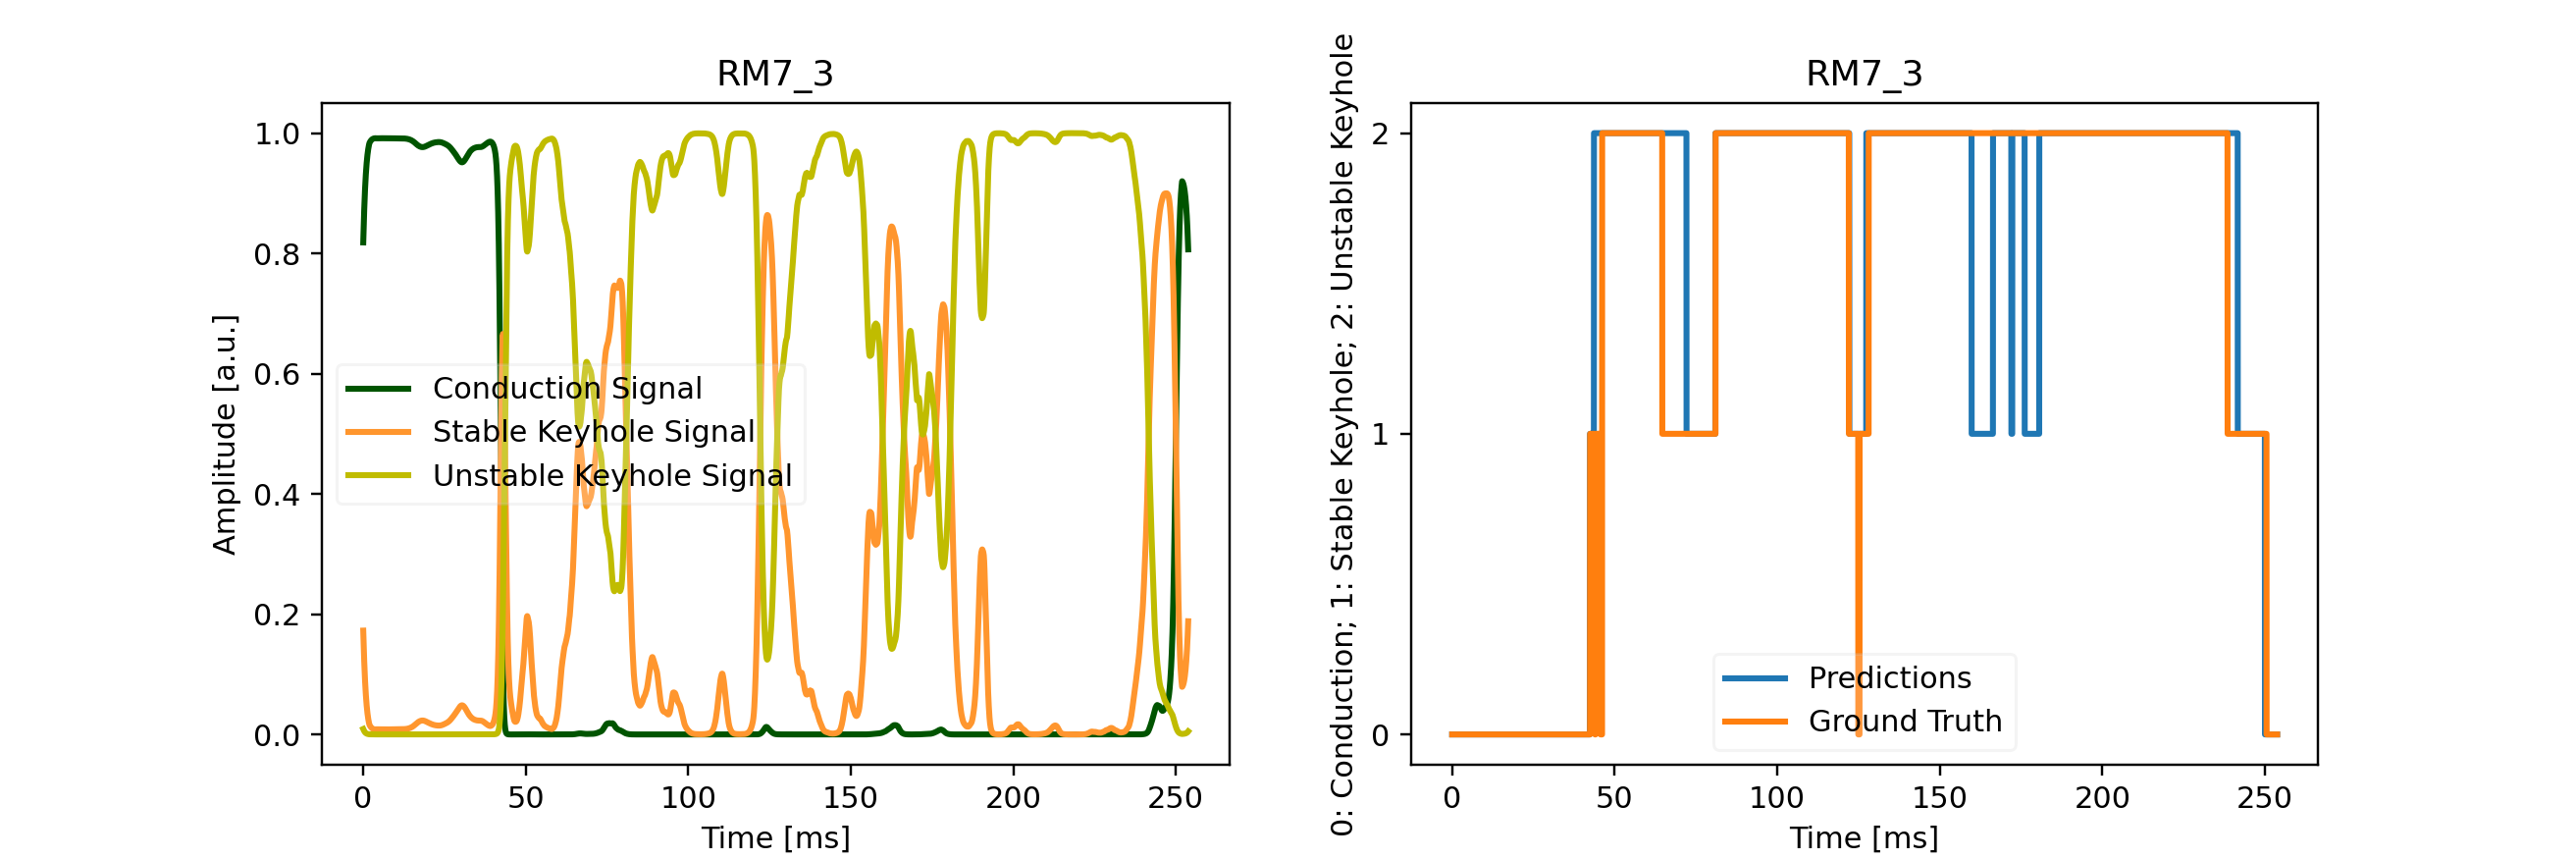

----------------------------------------------------------------------------------------------------


In [23]:
m = nn.Softmax(dim=1)
precision_calc = Precision(task='Multiclass', average='none', num_classes=3)
recall_calc = Recall(task='Multiclass', average='none', num_classes=3)

def process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, models_Unst, device, Fs):
    with torch.no_grad():
        name = names[outer]
        GT = GTs[outer].to(device)
        signal = xs[outer].to(device)
        
        time = np.linspace(start=0, stop=len(signal) * 1/Fs, num=len(signal)) * 1000
        prediction = models_Cond[i].cpu().to(device)
        predictionKH = models_KH[i].cpu().to(device)
        predictionUnst = models_Unst[i].cpu().to(device)
        
        x_Cond = prediction(signal)
        x_KH = predictionKH(signal)
        x_Unst = predictionUnst(signal)

        myPreds = torch.cat([x_Cond, x_KH, x_Unst], 1)
        output = m(myPreds)
        _, ind = torch.max(myPreds, 1)

        visualize_signal(time, output, ind, GT, name)
        
        score = F1(ind.long(), GT.view(-1).long()).cpu().detach().numpy()
        precision = precision_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()
        recall = recall_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()

        return name, score, precision, recall, GT.view(-1).long(), ind.long()

def visualize_signal(time, output, ind, GT, name):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time, output[:, 0].cpu(), label='Conduction Signal', linewidth=2, color=(0, 84/255, 0))
    axs[0].plot(time, output[:, 1].cpu(), label='Stable Keyhole Signal', linewidth=2, color=(1,150/255,46/255))
    axs[0].plot(time, output[:, 2].cpu(), label='Unstable Keyhole Signal', linewidth=2, color=(192/255, 188/255, 0))
    axs[1].plot(time, ind.cpu(), label='Predictions', linewidth=2)
    axs[1].plot(time, GT.cpu(), label='Ground Truth', linewidth=2)
    
    for ax, title in zip(axs, [name, name]):
        ax.set_title(title)
        ax.set_xlabel('Time [ms]')
        ax.legend(framealpha=0.2)
    axs[0].set_ylabel('Amplitude [a.u.]')
    axs[1].set_ylabel('0: Conduction; 1: Stable Keyhole; 2: Unstable Keyhole')
    axs[1].set_yticks([0, 1, 2])

    fig.set_size_inches(12, 4)
    plt.show()

overall_results = []
overall_preds = []
overall_GTs = []

for i, outer in enumerate(range(len(names))):
    name, scores, precisions, recalls, GT, preds = process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, models_Unst, device, Fs)
    overall_preds.append(preds)
    overall_GTs.append(GT)
    
    signal_metrics = {
        'Signal Name': name,
        'F1 Conduction': scores[0],
        'F1 Stable Keyhole': scores[1],
        'F1 Unstable Keyhole': scores[2],
        'Precision Conduction': precisions[0],
        'Precision Stable Keyhole': precisions[1],
        'Precision Unstable Keyhole': precisions[2],
        'Recall Conduction': recalls[0],
        'Recall Stable Keyhole': recalls[1],
        'Recall Unstable Keyhole': recalls[2]
    }

    # Print metrics for the current signal
    df_signal = pd.DataFrame([signal_metrics])
    display(df_signal.style.hide(axis='index'))
    print('-' * 100)

# Overall F1 score, precision, and recall across all signals
overall_score = F1(torch.cat(overall_preds), torch.cat(overall_GTs)).cpu().detach().numpy()
overall_prec = precision_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()
overall_rec = recall_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()

for j, regime in enumerate(['Conduction', 'Stable Keyhole', 'Unstable Keyhole']):
    overall_results.append({
        'Regime': regime,
        'Overall F1-score': overall_score[j],
        'Overall Precision': overall_prec[j],
        'Overall Recall': overall_rec[j]
    })

# Display the overall results table
df_overall = pd.DataFrame(overall_results)

### Overall Performance Metrics for Each Regime

Below, we present a summary table showcasing the model's overall performance across the entire dataset for each of the three regimes: Conduction, Stable Keyhole, and Unstable Keyhole. This table aggregates the results obtained using the LOOCV method and provides key metrics — F1-score, Precision, and Recall — for a holistic evaluation. This consolidated view enables us to assess the model's efficacy and reliability in differentiating between the three regimes.


In [24]:
display(df_overall.style.hide(axis='index'))

### Confusion Matrix Visualization 

In this section, we visualize the confusion matrix for our segmentation predictions in terms of percentages. This normalized representation provides a clearer insight into the model's performance relative to the number of instances for each class. It indicates the percentage of times each class was correctly predicted and the percentage of times misclassifications occurred.


<IPython.core.display.Javascript object>


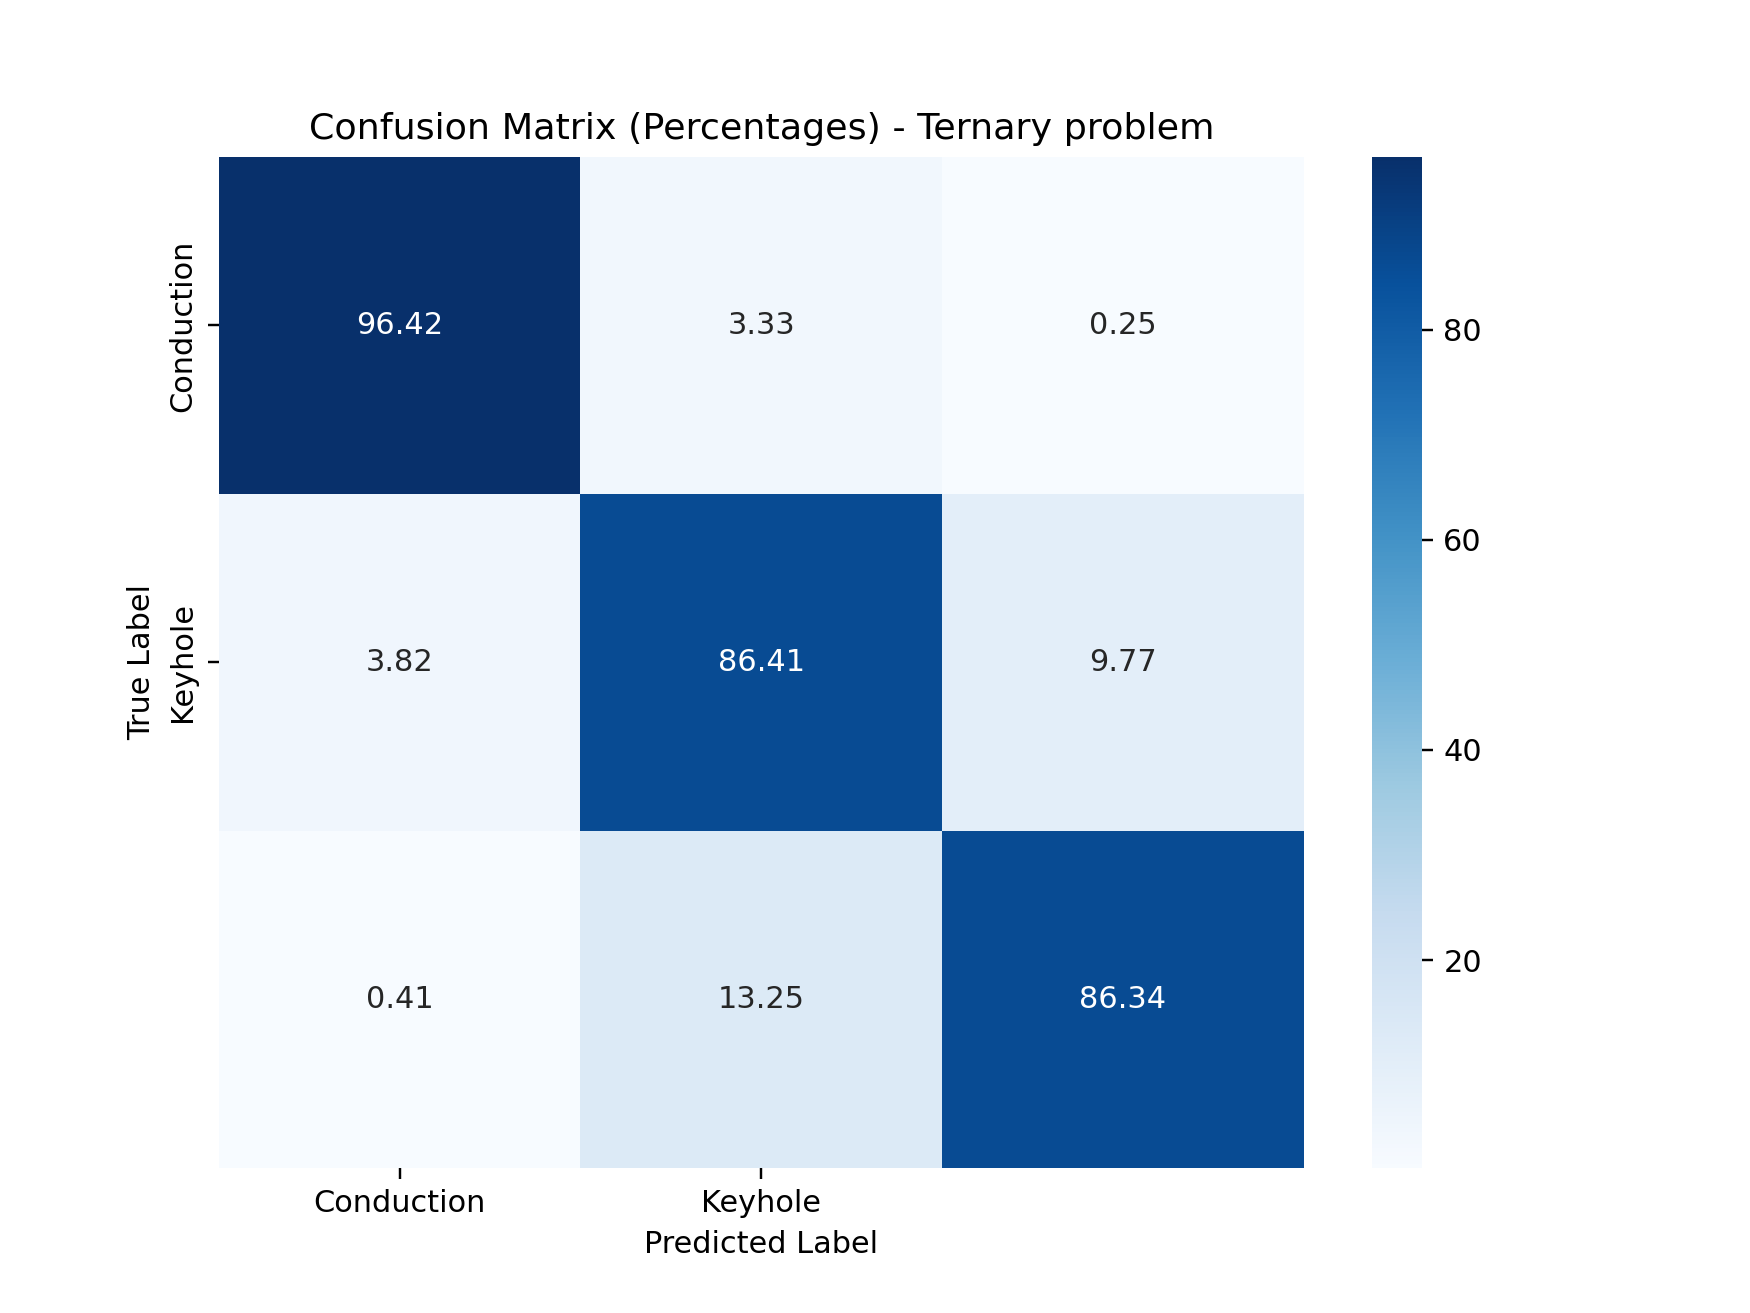

In [25]:
# Calculate the confusion matrix
cm = confusion_matrix(torch.cat(overall_GTs).cpu(), torch.cat(overall_preds).cpu())

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Conduction', 'Keyhole'], yticklabels=['Conduction', 'Keyhole'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Percentages) - Ternary problem')
plt.show()

---
**Disclaimer and Credits**

**Disclaimer**: This code is shared to promote transparency and further research. While every effort has been exerted to ensure its accuracy, we provide it "as-is" without warranties. Users are advised to utilize, adapt, and modify the code at their discretion and risk. The authors disclaim any liability arising from its use, including, but not limited to, errors or unintended outcomes.

**Credits**: The conceptualization and execution of this code are credited to Giulio Masinelli. Released under the CC0 license in accordance with Nature Communication's recommendations. Refer to the paper, "Harmonizing Sound and Light: X-Ray Imaging Unveils Acoustic Signatures of Stochastic Inter-Regime Instabilities during Laser Melting," for a comprehensive understanding.

**Contact**: For queries, further details, or opportunities related to this research segment, please connect with Giulio Masinelli at [giulio.masinelli@empa.ch](mailto:giulio.masinelli@empa.ch).

---